# COGS 108 - Final Project 

# Overview

In this project, we are going to examine the relationship between the trendiness on Google search engine of several candidates who are currently running for U.S. President 2020 and their fundraising results. For fundraising result of each candidate, we mainly focus on the following three factors: total contribution amount raised, total number of donors and total contribution amount by each census region. By analyzing the trendiness data from GoogleTrends, we wish we can find out how the number of times people search about each candidate online influences the donation he/she obtains from the public.


# Names

- Kartik Bhatnagar
- Kai-Chin Shih 
- Sahana Srinivasan
- (Isaac) Fangzheng Xie 
- (Gin) Xiaojin Zheng 

# Group Members IDs

- A14020665
- A12879790
- A13741839
- A13768347
- A15674894

# Research Question

Are candidates' trendiness on search engines, particularly Google, indicative of fundraising results？
   -Is there a correlation between a candidate’s trendiness on Google and the total contribution amount raised on each day for this candidate?
   -Is there a correlation between a candidate’s trendiness on Google and the total number of unique donors a candidate has?
   -Is there a correlation between a candidate's trendiness on Google and the total contribution amount in each U.S. Census Bureau Region and Division for each candidate?


## Background and Prior Work

The race to become the Democratic Party's frontrunner to take on Trump in 2020 has already begun. More then 25 Democrats have already declared their candidacy for POTUS and have begun campaigning and fundraising. In recent years, campaign funds available to candidates have increasingly determined the way elections pan out. More campaign contributions mean more visibility, more rallies and more opportunties for outreach for candidates, and it can subsquently often be the difference between a win and a loss. 

Social media and online visibility has also played an increasingly important role in a candidate's outreach and momentum. In recent elections, it has completely changed the way candidates interact with their audiences, attract volunteers and gain campaign contributions. Also, with more and more candidates rejecting Super Pac contributions and large donations by corporations, campaign donations by actual voters on a small scale are becoming pivotal to the effectiveness of a candidate's campaign. The volume and distributions of these donations can potentially provide interesting insights into a candidate's viability because it, in a sense, reflects the enthusiasm for the campaign.

In this project, we attempt to more closely examine the correlations between online visibility of a candidate, and the campaign contributions recieved by them. We hope to explore how a candidate's Google search trends relate to the amount of funds raised by them, the number of unique donations they recieve, and the geoographical relationships between their online visibilty and donation rates.

# Hypothesis

Our hypothesis is that the total contributions, total number of unique donors, and total contribution amount by each census region will increase when the candidates’ trendiness rises. In other words, we believe that the correlation between the two will be positive, and that they will be associated. But, we are not claiming that there is causation, or that a candidate's trendiness on Google causes an increase in donations.

The premise of our assumption is that the more people research a candidate, the more interest there is in a candidate, which could be reflected in increased contribution, as contribution is a prime mechanism for expressing interest.


# Dataset(s)

1. Bernie Sanders datasets: <br>
Dataset 1 Name: bernietrend.csv <br>
Link to the dataset: https://trends.google.com/trends/explore?q=%2Fm%2F01_gbv&geo=US <br>
Description: Google search trends for Bernie Sanders<br>
Dataset 2 Name: FEC_Bernie2020.csv <br>
Link to the dataset: https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2020&committee_id=C00696948&min_date=01%2F01%2F2019&max_date=12%2F31%2F2020 <br>
Description: Individual FEC contribution records for Bernie Sanders<br><br>
2. Beto O’Rourke datasets: <br>
Dataset 3 Name: betotrend.csv <br>
Link to the dataset: https://trends.google.com/trends/explore?geo=US&q=%2Fm%2F0dty9d <br>
Description: Google search trends for Beto O’Rourke <br>
Dataset 4 Name: FEC_Beto2020.csv <br>
Link to the dataset: https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2020&committee_id=C00699090&min_date=01%2F01%2F2019&max_date=12%2F31%2F2020 <br>
Description: Individual FEC contribution records for Beto O’Rourke <br><br>
3. Kamala Harris datasets: <br>
Dataset 5 Name: kamalatrend.csv <br>
Link to the dataset: https://trends.google.com/trends/explore?geo=US&q=%2Fm%2F08sry2 <br>
Description: Google search trends for Kamala Harris <br>
Dataset 6 Name: FEC_Kamala2020.csv <br>
Link to the dataset: https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2020&committee_id=C00694455&min_date=01%2F01%2F2019&max_date=12%2F31%2F2020 <br>
Description: Individual FEC contribution records for Kamala Harris

# Setup

In [1]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

import shapely.geometry as shp

import sklearn.neighbors as skn
import sklearn.metrics as skm

pd.options.display.max_rows = 10

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Data Cleaning & Exploration

### I. To check candidates popularity through Google searches through time

In [3]:
#Bernie Sanders
# Load Google Trends csv file as dataframe
dfBSTrend = pd.read_csv('bernietrend.csv')
# Set column names
dfBSTrend.columns = ['date','trend']
# Change data type from strings to number and date
dfBSTrend['trend'] = dfBSTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
dfBSTrend['date'] = dfBSTrend['date'].astype('datetime64')

#Beto O'Rourke
# Load Google Trends csv file as dataframe
dfBOTrend = pd.read_csv('betotrend.csv')
# Set column names
dfBOTrend.columns = ['date','trend']
# Change data type from strings to number and date
dfBOTrend['trend'] = dfBOTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
dfBOTrend['date'] = dfBOTrend['date'].astype('datetime64')

# Kamala Harris
# Load Google Trends csv file as dataframe
dfKHTrend = pd.read_csv('kamalatrend.csv')
# Set column names
dfKHTrend.columns = ['date','trend']
# Change data type from strings to number and date
dfKHTrend['trend'] = dfKHTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
dfKHTrend['date'] = dfKHTrend['date'].astype('datetime64')

Text(0.5, 1.0, 'Kamala Harris Google Trendiness By Date')

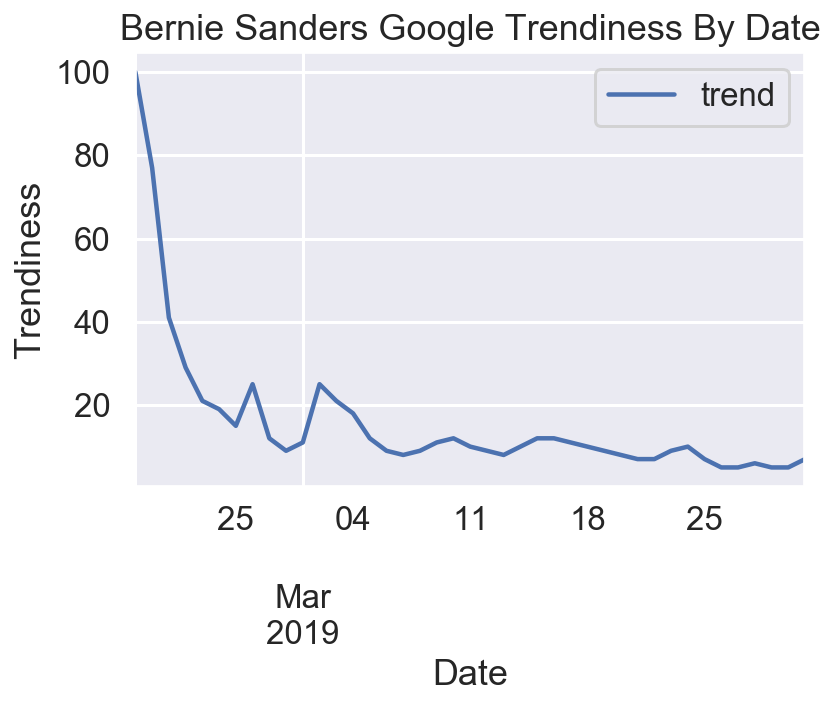

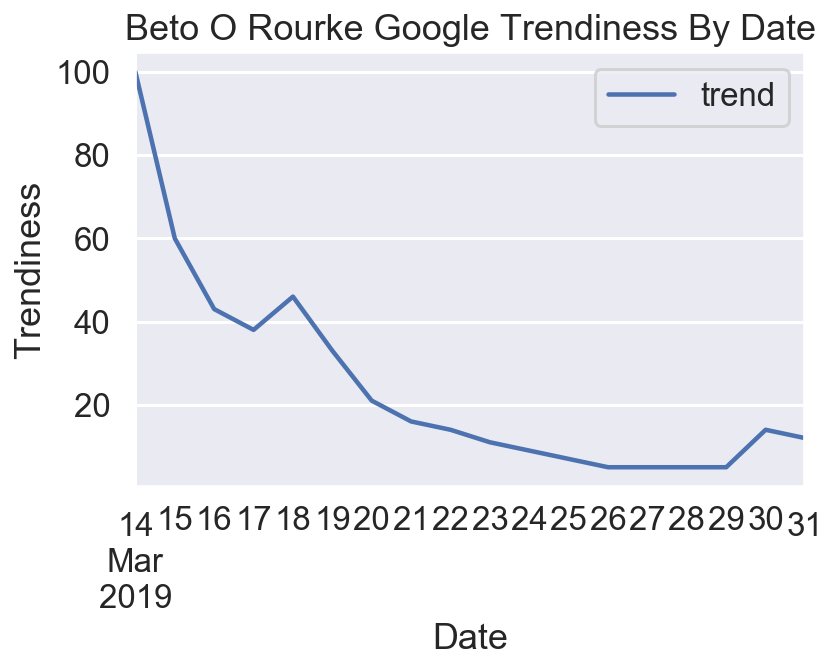

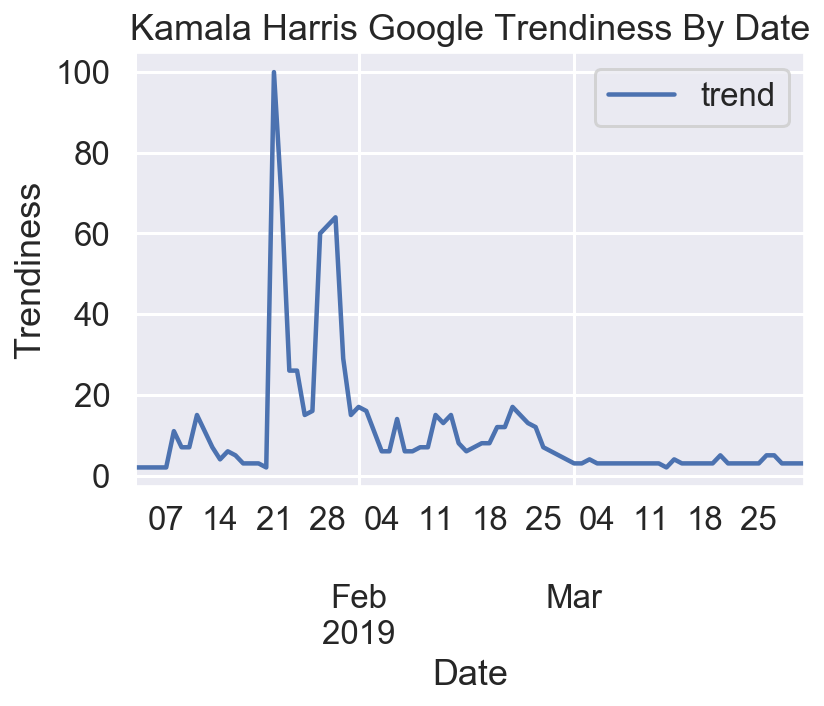

In [4]:
#Bernie Sanders
#Plot the trend and add appropriate axis labels 
bernie = dfBSTrend.plot(x='date', y='trend')
bernie.set_xlabel('Date')
bernie.set_ylabel('Trendiness')
bernie.set_title('Bernie Sanders Google Trendiness By Date')

#Beto O'Rourke
#Plot the trend and add appropriate axis labels
beto = dfBOTrend.plot(x = 'date', y = 'trend')
beto.set_xlabel('Date')
beto.set_ylabel('Trendiness')
beto.set_title('Beto O Rourke Google Trendiness By Date')

# Kamala Harris
#Plot the trend and add appropriate axis labels
kamala = dfKHTrend.plot(x = 'date', y = 'trend') 
kamala.set_xlabel('Date')
kamala.set_ylabel('Trendiness')
kamala.set_title('Kamala Harris Google Trendiness By Date')

The graphs above describe the trendiness of each candidate from the time they announced their candidacies to the final date through which FEC data on each candidate is available. Though each candidate's graph has a different starting point, the FEC data for all candidates ends at the end of March. As the graphs demonstrate, candidates appear to peak in popularity at (or near) the beginning of their entrance into the race. Then, their popularity seems to level off. There are some exceptions to this trend, however. These surges in popularity are likely attributable to major political events that a candidate involved him or herself in.

### II. To check total donation volume to candidates through FEC data by time trend

In [5]:
#Bernie Sanders
#Load FEC campaign contribution file as dataframe
dfBSFEC = pd.read_csv('FEC_Bernie2020.csv')
# Set column names
dfBSFEC = dfBSFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
# Change data type from string to date or numeric form
dfBSFEC['contribution_receipt_date'] = dfBSFEC['contribution_receipt_date'].astype("datetime64")
dfBSFEC['contribution_receipt_amount'] = dfBSFEC['contribution_receipt_amount'].apply(pd.to_numeric)

#Beto O'Rourke
#Load FEC campaign contribution file as dataframe
dfBOFEC = pd.read_csv('FEC_Beto2020.csv')
# Set column names
dfBOFEC = dfBOFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
# Change data type from string to date or numeric form
dfBOFEC['contribution_receipt_date'] = dfBOFEC['contribution_receipt_date'].astype("datetime64")
dfBOFEC['contribution_receipt_amount'] = dfBOFEC['contribution_receipt_amount'].apply(pd.to_numeric)

#Kamala Harris
#Load FEC campaign contribution file as dataframe
dfKHFEC = pd.read_csv('FEC_Kamala2020.csv')
# Set column names
dfKHFEC = dfKHFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
# Change data type from string to date or numeric form
dfKHFEC['contribution_receipt_date'] = dfKHFEC['contribution_receipt_date'].astype("datetime64")
dfKHFEC['contribution_receipt_amount'] = dfKHFEC['contribution_receipt_amount'].apply(pd.to_numeric)

/Users/kaichinshih/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kaichinshih/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (35,36,37,38,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kaichinshih/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (35,36,37,38,39,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'Total Contribution Amount By Date to Harris')

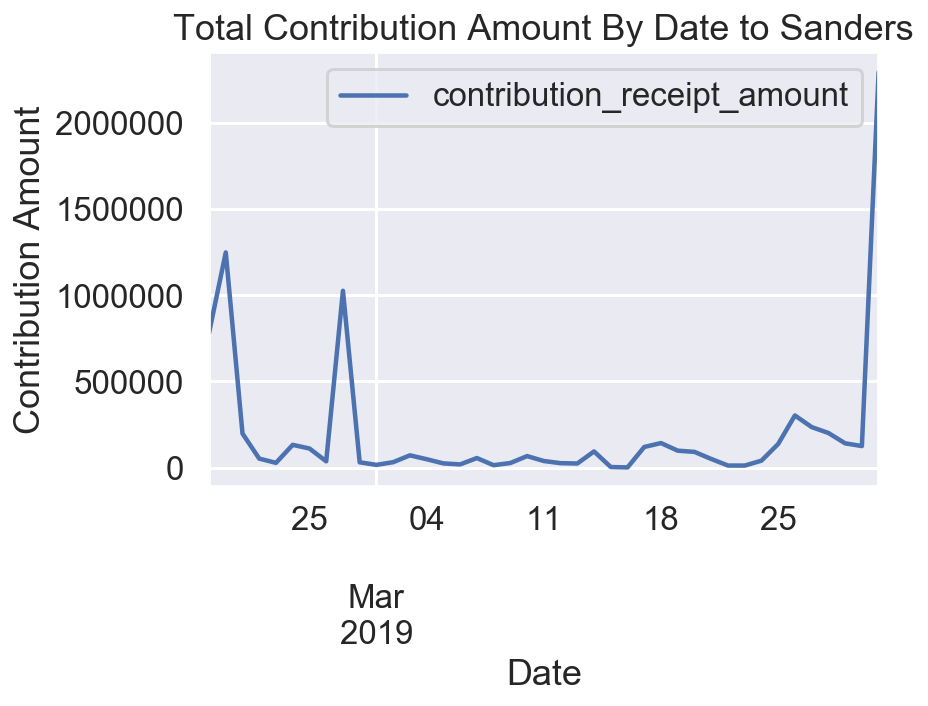

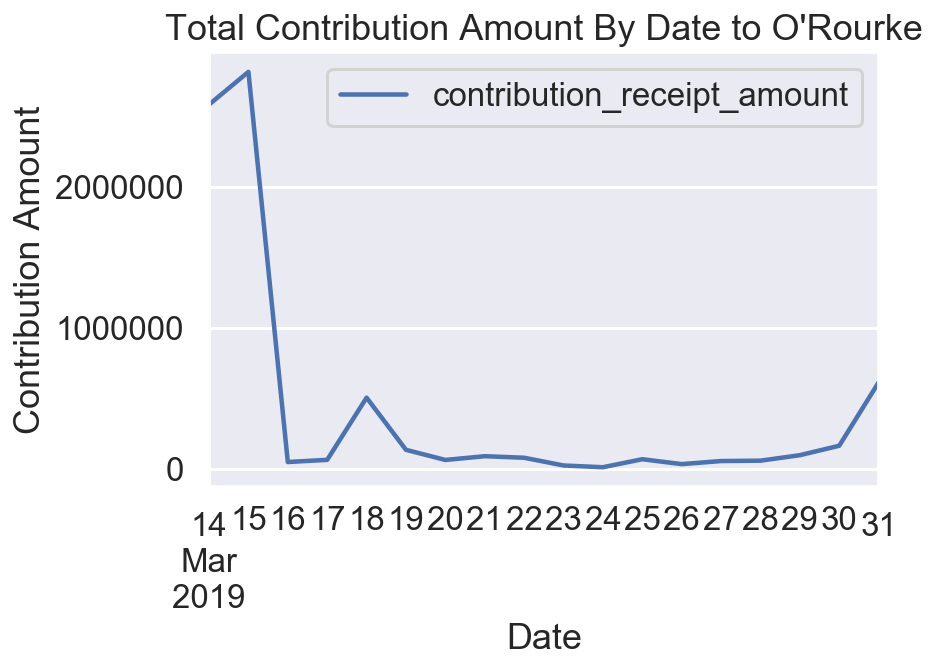

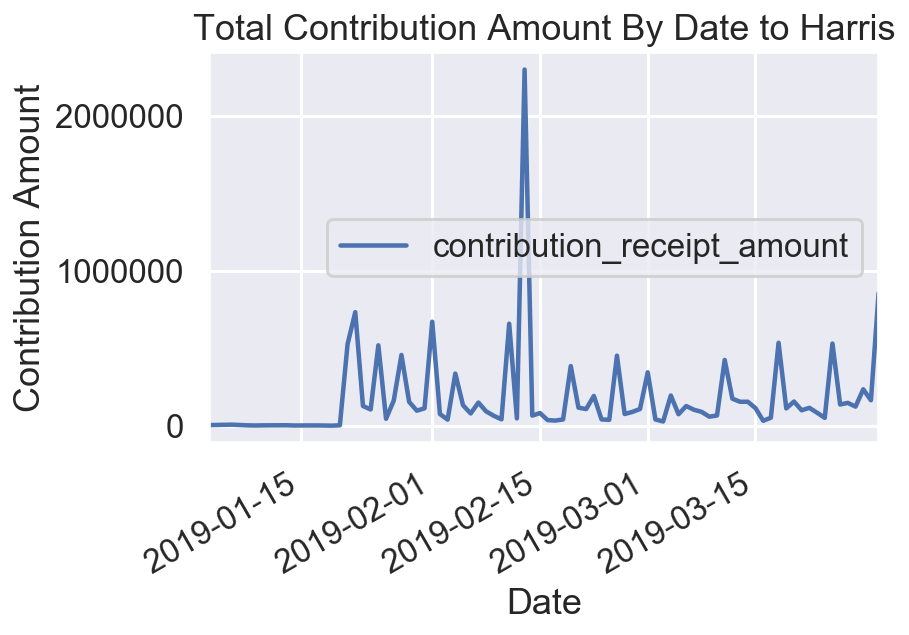

In [6]:
# Bernie Sanders
# Create pivot table to obtain total amount raised for each day
dfBSAmount = pd.pivot_table(dfBSFEC, index=['contribution_receipt_date'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name as date
dfBSAmount.index.names = ['date']
# Plot Bernie daily contribution amounts
bernie2 = dfBSAmount.plot()
# Set graph appearance
bernie2.set_xlabel('Date')
bernie2.set_ylabel('Contribution Amount')
bernie2.set_title('Total Contribution Amount By Date to Sanders')

# Beto O'Rourke
# Create pivot table to obtain total amount raised for each day
dfBOAmount = pd.pivot_table(dfBOFEC, index = ['contribution_receipt_date'], values = ["contribution_receipt_amount"], aggfunc = np.sum)
# Set column name as date
dfBOAmount.index.names = ['date']
# Plot Beto daily contribution amounts
beto2 = dfBOAmount.plot() 
# Set graph appearance
beto2.set_xlabel('Date')
beto2.set_ylabel('Contribution Amount')
beto2.set_title('Total Contribution Amount By Date to O\'Rourke')

# Kamala Harris
# Create pivot table to obtain total amount raised for each day
dfKHAmount = pd.pivot_table(dfKHFEC, index = ['contribution_receipt_date'], values = ["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name as date
dfKHAmount.index.names = ['date']
# Plot Kamala daily contribution amounts
kamala2 = dfKHAmount.plot()
# Set graph appearance
kamala2.set_xlabel('Date')
kamala2.set_ylabel('Contribution Amount')
kamala2.set_title('Total Contribution Amount By Date to Harris')

The graphs above depict the total amount of contribution to a given candidate from the start of the announcment of their candidacy to the end of March. Each candidate's contribution amount seems to peak at different times; the trend is not as consistent across candidates as it was for the trendiness data. We theorize that surges in popularity are associated with pivotal moments associated with a candidate that capture the attention of their voting base. While Sanders and O'Rourke experience a surge in funding at the beginning of their campaigns, Harris received a surge nearly a month after, one that was likely a byproduct of her political campaigning and townhalls.

### III. To check total donation actions to candidates through FEC data by time trend

Text(0.5, 1.0, 'Total Transactions By Date to Harris')

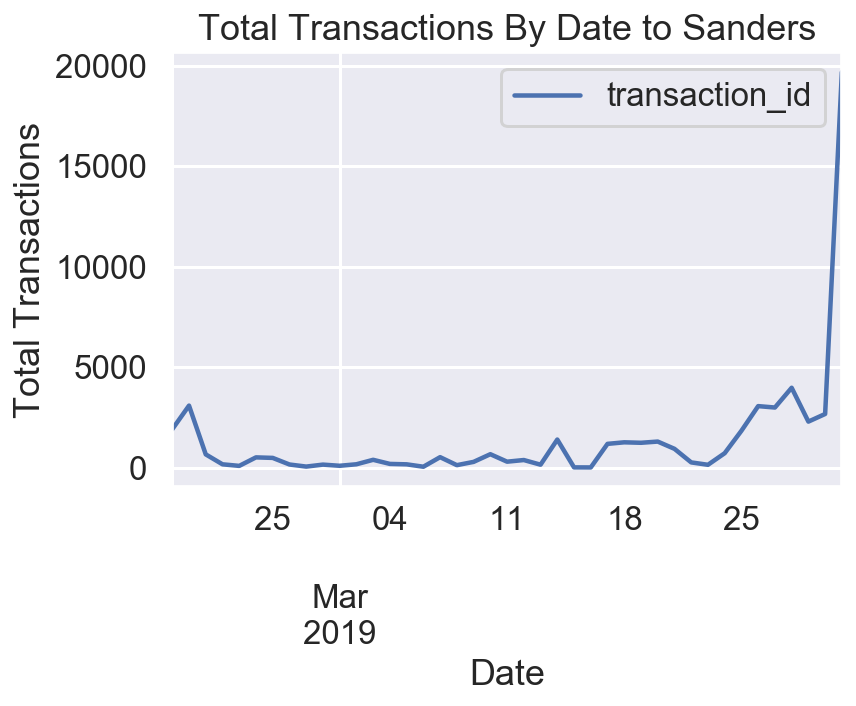

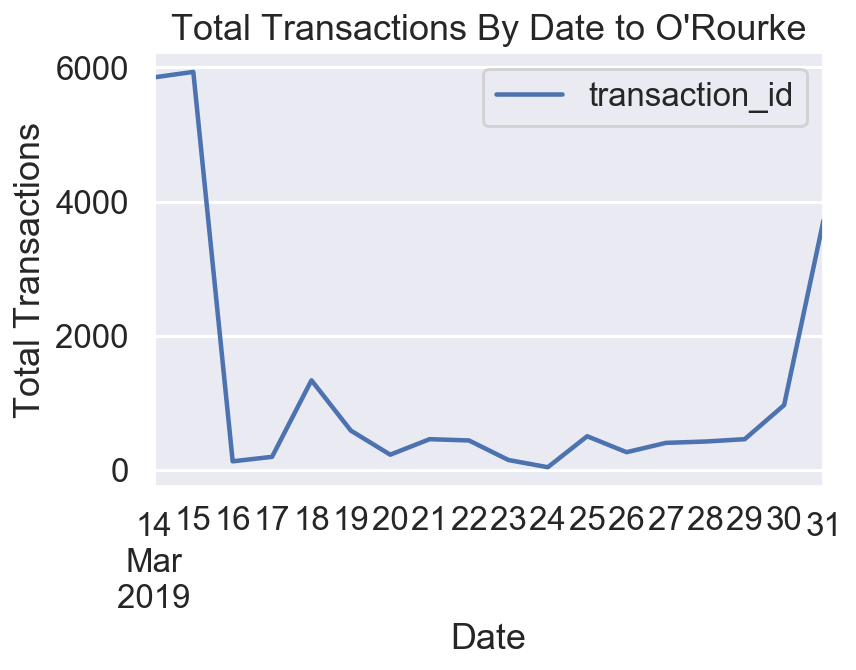

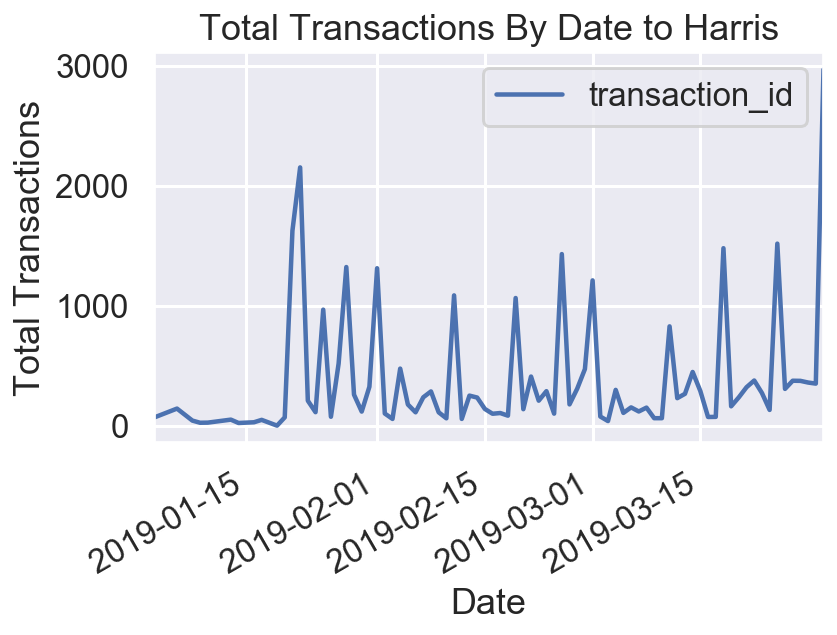

In [7]:
# Bernie Sanders
# Create pivot table to obtain total number of transactions each day
dfBSDonors = pd.pivot_table(dfBSFEC, index=["contribution_receipt_date"],values=["transaction_id"], aggfunc=lambda x: len(x.unique()))
# Set column name
dfBSDonors.index.names = ['date']
# Plot total number of transactions
bernie3 = dfBSDonors.plot()
# Set graph appearance
bernie3.set_xlabel('Date')
bernie3.set_ylabel('Total Transactions')
bernie3.set_title('Total Transactions By Date to Sanders')

# Beto O'Rourke
# Create pivot table to obtain total number of transactions each day
dfBODonors = pd.pivot_table(dfBOFEC, index=["contribution_receipt_date"],values=["transaction_id"], aggfunc=lambda x: len(x.unique()))
# Set column name
dfBODonors.index.names = ['date']
# Plot total number of transactions
beto3 = dfBODonors.plot()
# Set graph appearance
beto3.set_xlabel('Date')
beto3.set_ylabel('Total Transactions')
beto3.set_title('Total Transactions By Date to O\'Rourke')

# Kamala Harris
# Create pivot table to obtain total number of transactions each day
dfKHDonors = pd.pivot_table(dfKHFEC, index=["contribution_receipt_date"],values=["transaction_id"], aggfunc=lambda x: len(x.unique()))
# Set column name
dfKHDonors.index.names = ['date']
# Plot total number of transactions
kamala3 = dfKHDonors.plot()
# Set graph appearance
kamala3.set_xlabel('Date')
kamala3.set_ylabel('Total Transactions')
kamala3.set_title('Total Transactions By Date to Harris')

The graphs above track the total number of unique donors (or transactions) to a candidate from the same time range used in the previous graphs. There is certainly the least consistency amongst these graphs between each candidate. However, there does appear to be a correlation between the total number of unique donors to the total contribution amount, which suggests that the source of contributions is most likely not a single, dominant donor.

### IV. To check candidates popularity through google searching trend by state

In [8]:
# Bernie Sanders
# Load Google Trends by state file into dataframe
dfBSTrendStates = pd.read_csv('bernietrend_state.csv')
# Set column names
dfBSTrendStates.columns = ['state','trend']
# Change data type to numeric
dfBSTrendStates['trend'] = dfBSTrendStates['trend'].apply(pd.to_numeric, errors = 'coerce')

# Beto O'Rourke
# Load Google Trends by state file into dataframe
dfBOTrendStates = pd.read_csv('betotrend_state.csv')
# Set column names
dfBOTrendStates.columns = ['state','trend']
# Change data type to numeric
dfBOTrendStates['trend'] = dfBOTrendStates['trend'].apply(pd.to_numeric, errors = 'coerce')

# Kamala Harris
# Load Google Trends by state file into dataframe
dfKHTrendStates = pd.read_csv('kamalatrend_state.csv')
# Set column names
dfKHTrendStates.columns = ['state','trend']
# Change data type to numeric
dfKHTrendStates['trend'] = dfKHTrendStates['trend'].apply(pd.to_numeric, errors = 'coerce')

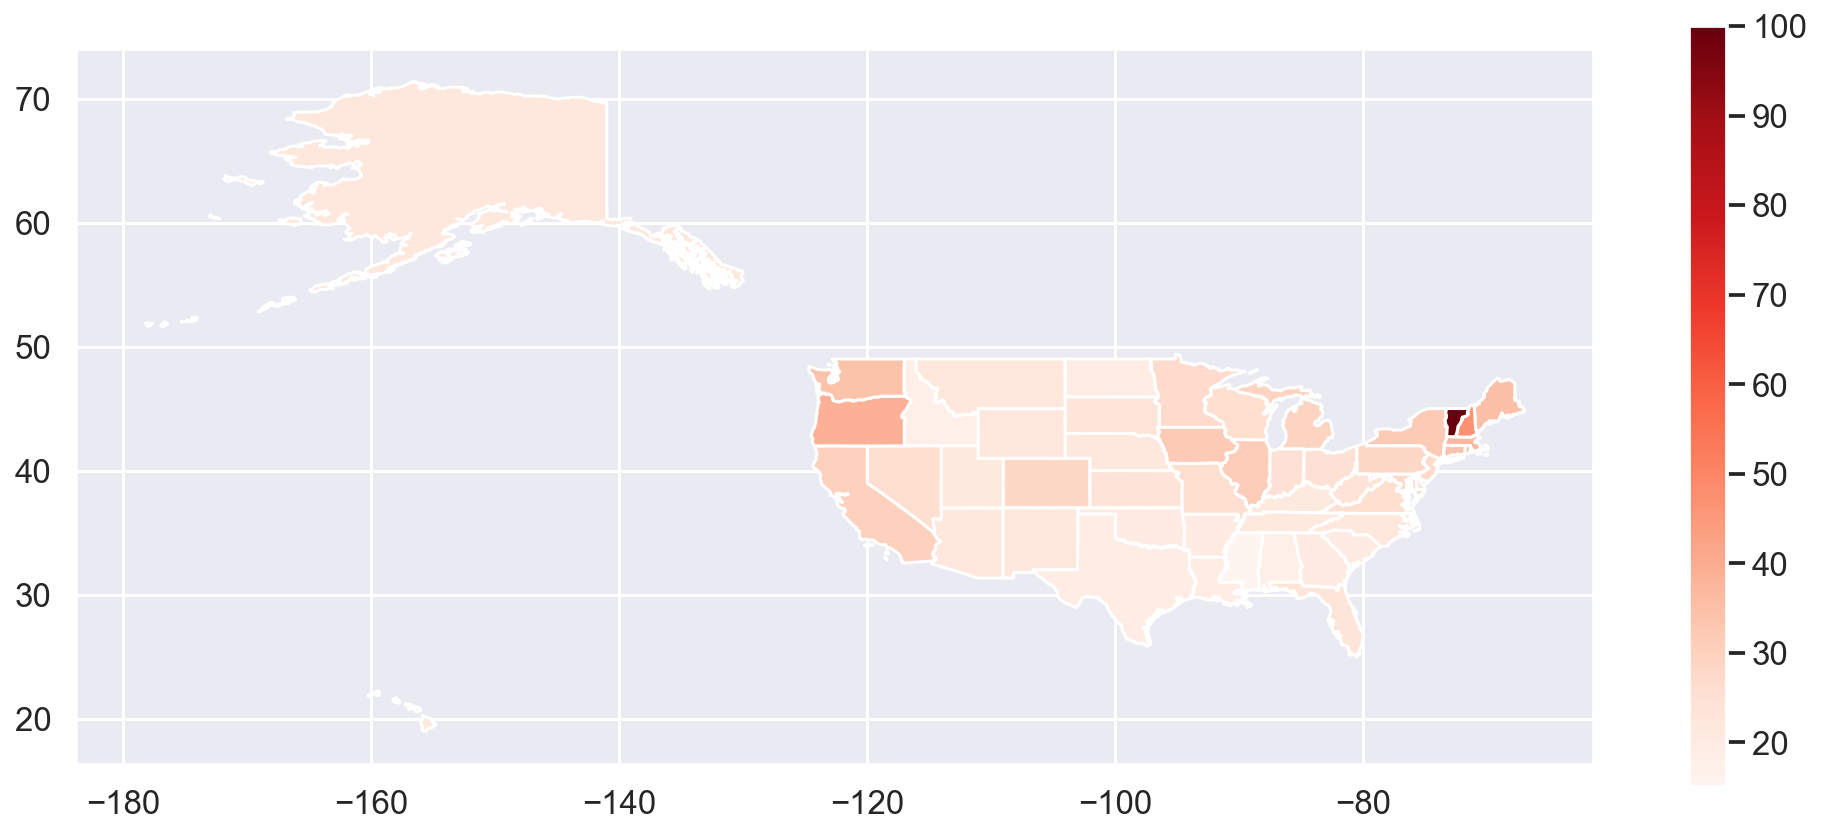

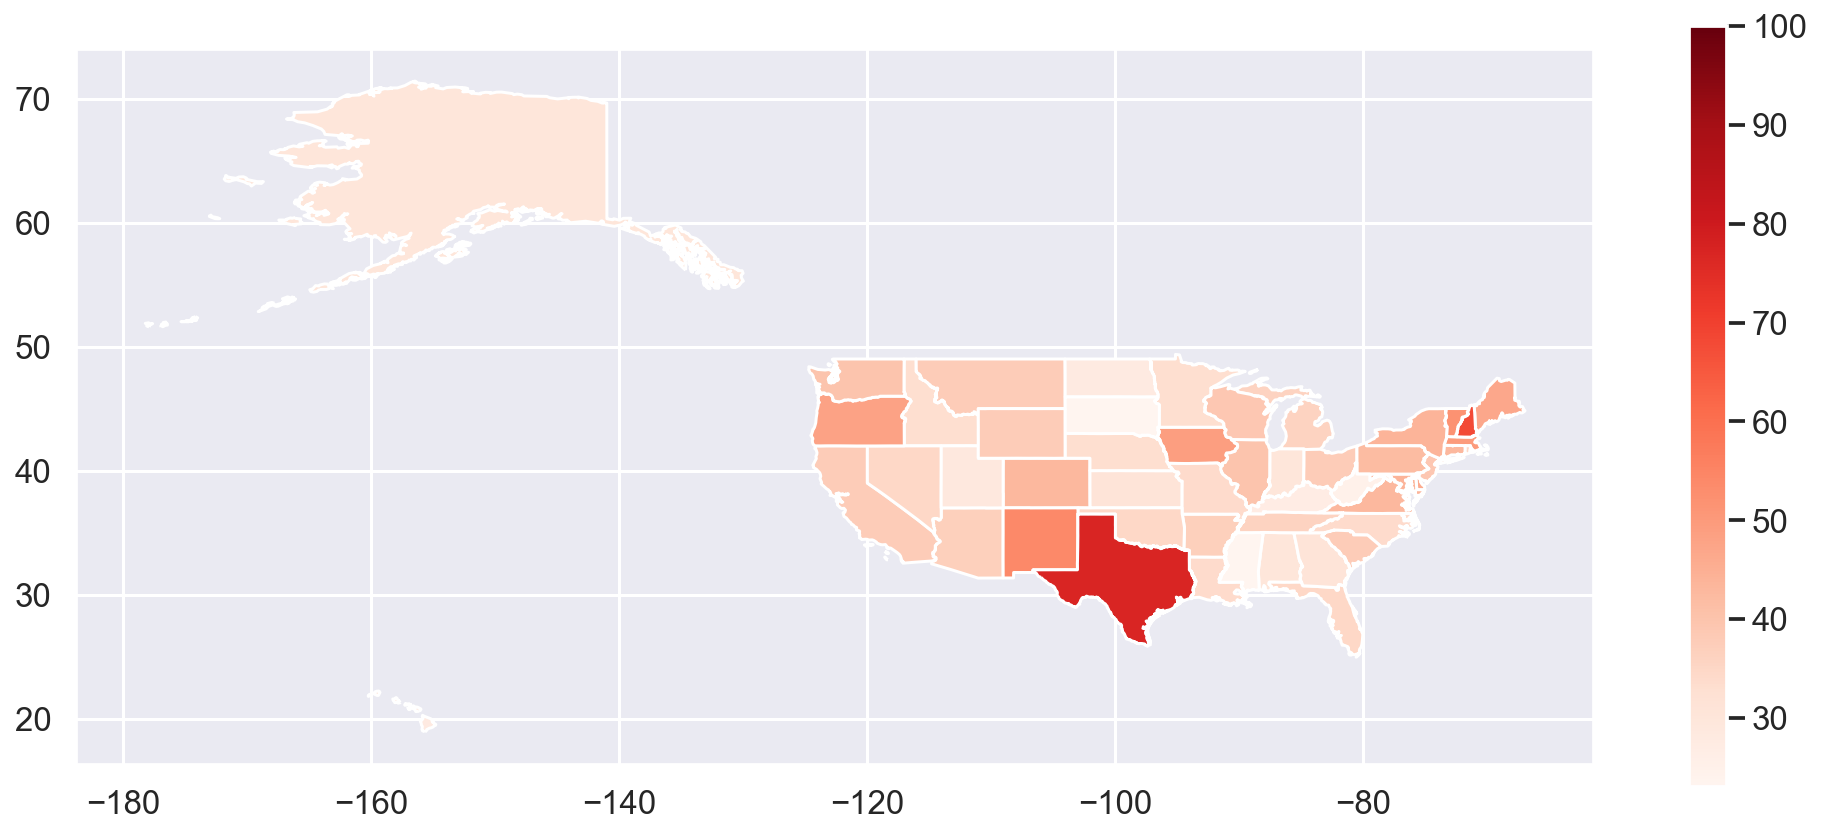

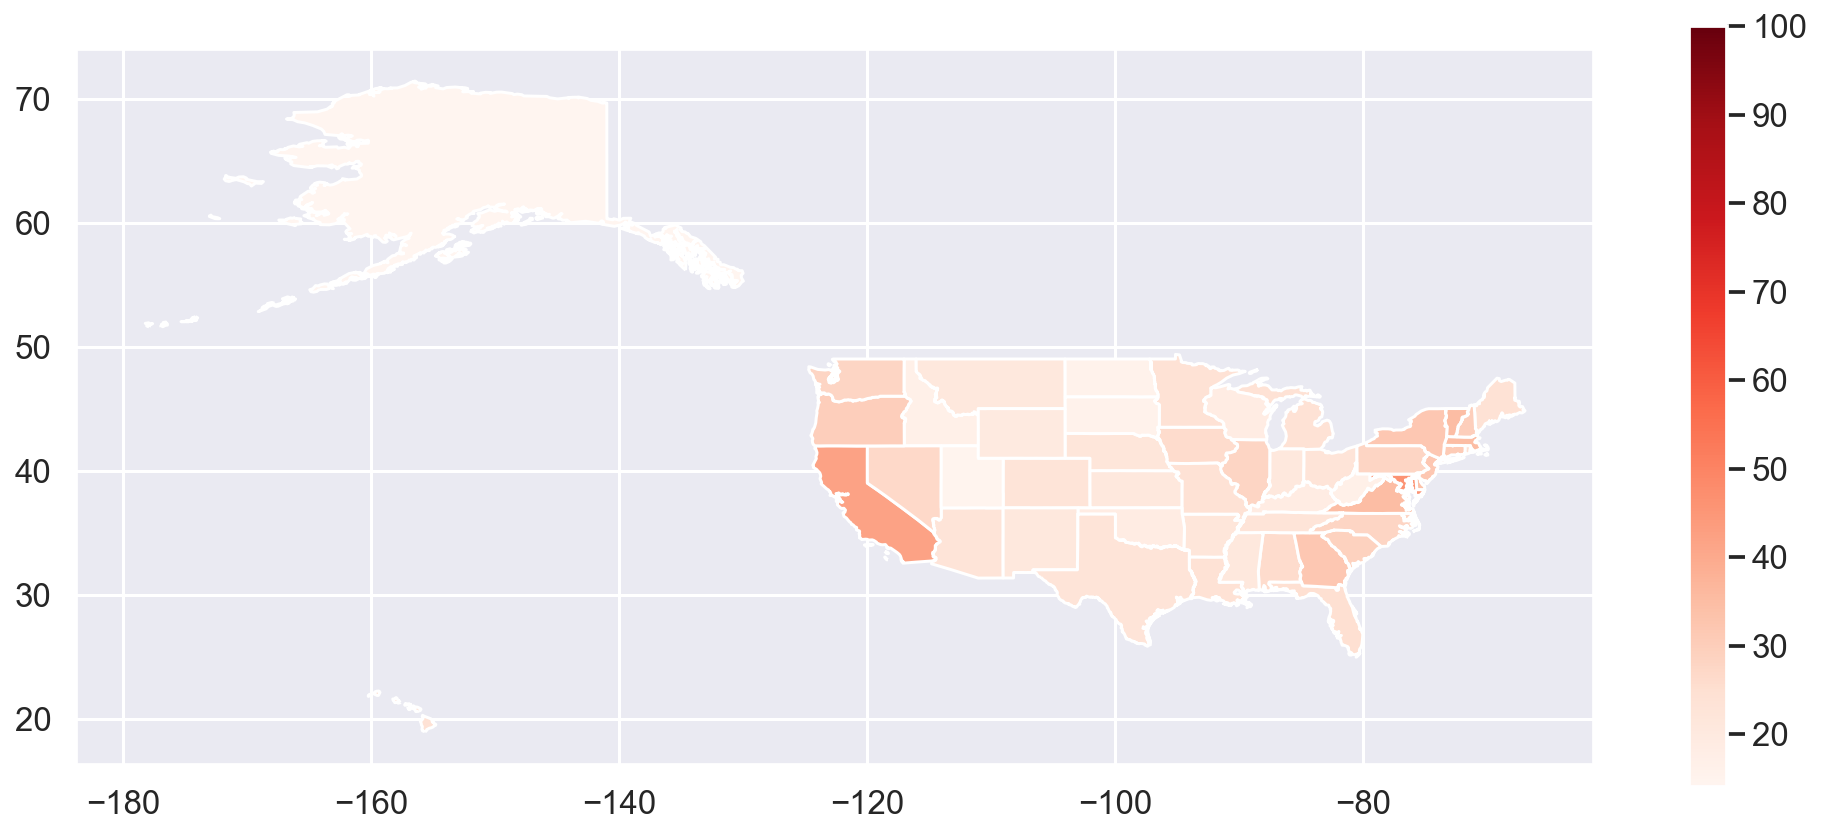

In [9]:
# Loading shape data for mapping
usa = gpd.read_file('./states_21basic/states.shp')
usa = usa.sort_values(by=['STATE_NAME'])

# Bernie Sanders
# Plot Bernie popularity by state onto US map
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=dfBSTrendStates['trend'],ax=ax, cmap='Reds', legend=True);

# Beto O'Rourke
# Plot Beto popularity by state onto US map
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=dfBOTrendStates['trend'],ax=ax, cmap='Reds', legend=True);

# Kamala Harris
# Plot Kamala popularity by state onto US map
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=dfKHTrendStates['trend'],ax=ax, cmap='Reds', legend=True);

### V. Total contribution amount based on U.S. Census Bureau Divisions

In [10]:
# Bernie Sanders
# Create pivot table to obtain total amount raised by state
dfBSStates = pd.pivot_table(dfBSFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name
dfBSStates.index.names = ['state']

# Beto O'Rourke
# Create pivot table to obtain total amount raised by state
dfBOStates = pd.pivot_table(dfBOFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name
dfBOStates.index.names = ['state']

# Kamala Harris
# Create pivot table to obtain total amount raised by state
dfKHStates = pd.pivot_table(dfKHFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name
dfKHStates.index.names = ['state']

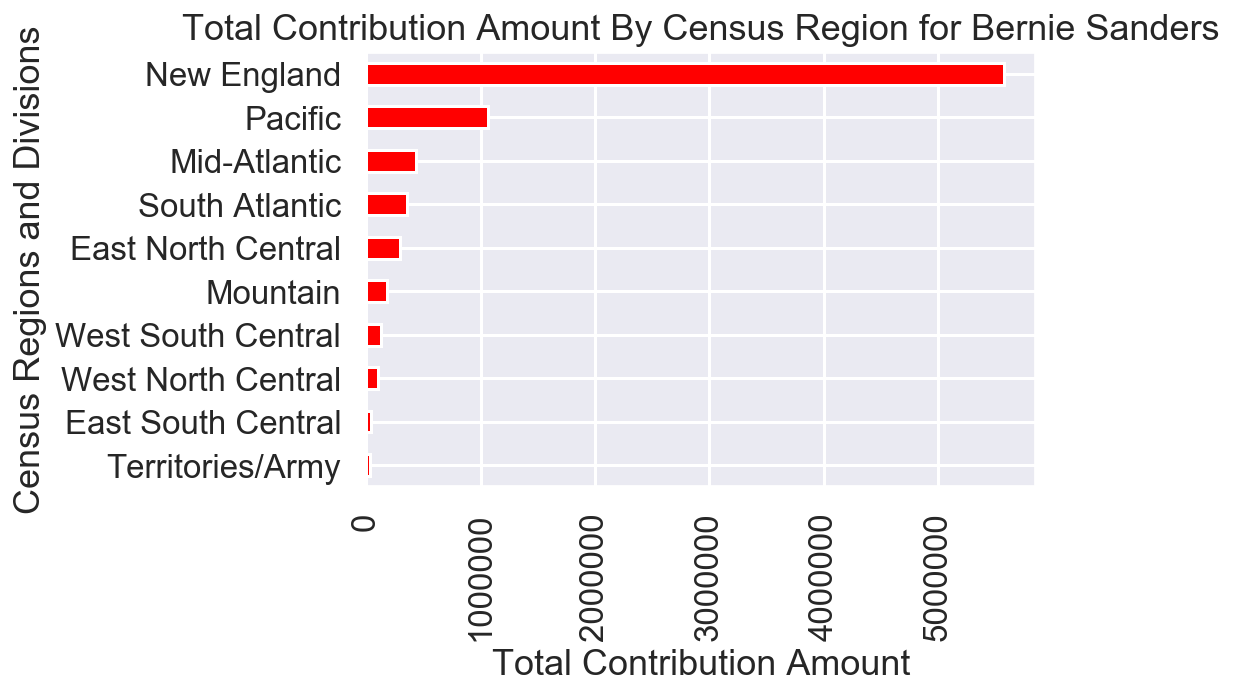

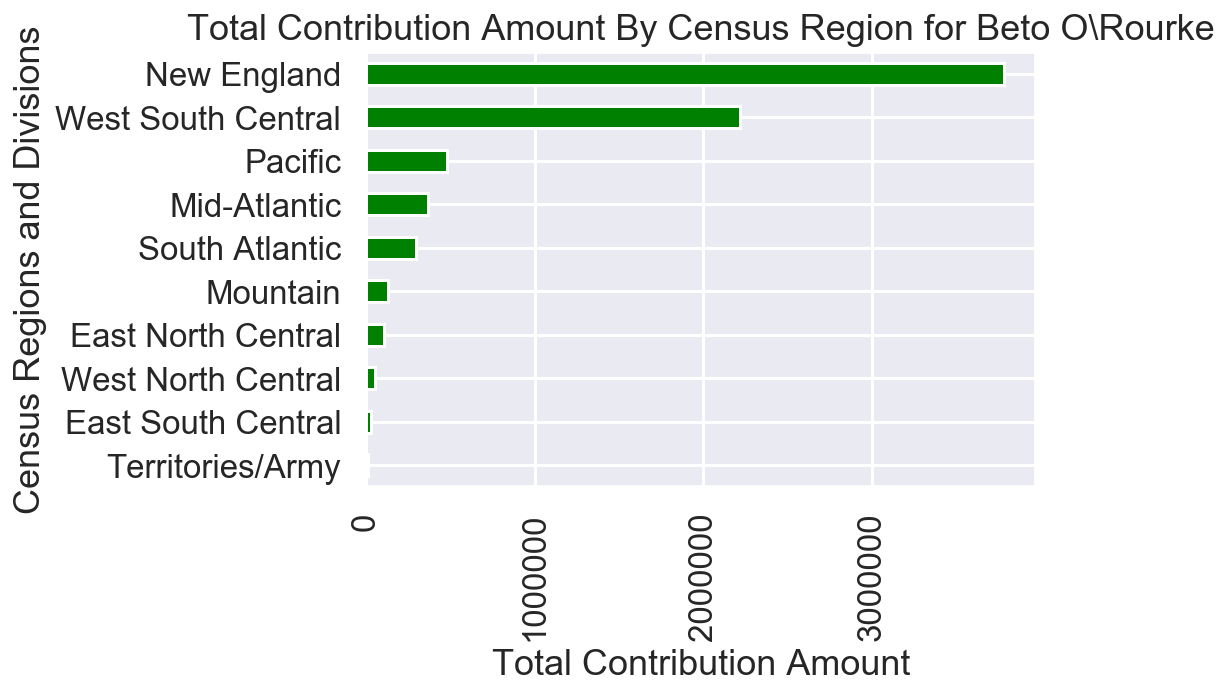

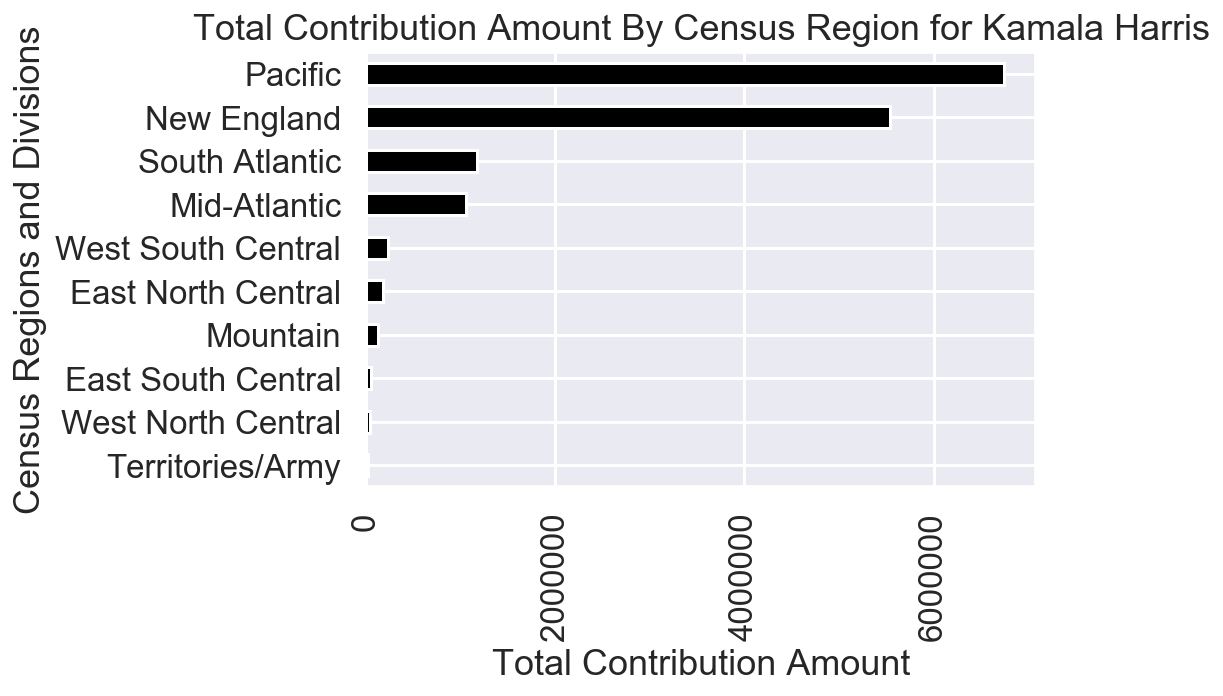

In [11]:
# Census Bureau Division Version
from collections import defaultdict
# Bernie Sanders Fundraising by USCB Division
# Create pivot table to obtain total amount raised by state
# This pivot table is used to aggregate contributions by division
dfBSDivision = pd.pivot_table(dfBSFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name
dfBSDivision.index.names = ['contributor_state']
dfBSDivision['Division'] = ""
dfBSDivision['Division Total'] = ""

# Dictionary of state abbreviations with division
state2division = {'AA': 'Territories/Army', 'AE': 'Territories/Army', 'AK': 'Pacific', 'AL': 'East South Central', 'AP': 'Territories/Army', 'AR': 'West South Central', 'AS': 'Territories/Army', 'AZ': 'Mountain', 'CA': 'Pacific', 'CO': 'Mountain', 'CT': 'New England', 'DC': 'South Atlantic', 'DE': 'South Atlantic', 'FL': 'South Atlantic', 'GA': 'South Atlantic', 'GU': 'Territories/Army', 'HI': 'Pacific', 'IA': 'West North Central', 'ID': 'Mountain', 'IL': 'East North Central', 'IN': 'East North Central', 'KS': 'West North Central', 'KY': 'East South Central', 'LA': 'West South Central', 'MA': 'New England', 'MD': 'South Atlantic', 'ME': 'New England', 'MI': 'East North Central', 'MN': 'West North Central', 'MO': 'West North Central', 'MP': 'Territories/Army', 'MS': 'East South Central', 'MT': 'Mountain', 'NC': 'South Atlantic', 'ND': 'West North Central', 'NE': 'West North Central', 'NH': 'New England', 'NJ': 'Mid-Atlantic', 'NM': 'Mountain', 'NV': 'Mountain', 'NY': 'Mid-Atlantic', 'OH': 'East North Central', 'OK': 'West South Central', 'OR': 'Pacific', 'PA': 'Mid-Atlantic', 'PR': 'Territories/Army', 'RI': 'New England', 'SC': 'South Atlantic', 'SD': 'West North Central', 'TN': 'East South Central', 'TX': 'West South Central', 'UT': 'Mountain', 'VA': 'South Atlantic', 'VI': 'Territories/Army', 'VT': 'New England', 'WA': 'Pacific', 'WI': 'East North Central', 'WV': 'South Atlantic', 'WY': 'Mountain', 'ZZ': 'Territories/Army'}

# Add division data to original table
for i, row in dfBSDivision.iterrows():
    dfBSDivision.at[i,'Division'] = state2division[i]
    
# Create pivot table to obtain total amount raised in each region
dfBSDivision_State = pd.pivot_table(dfBSDivision, index=['Division'],values=["contribution_receipt_amount"],aggfunc=np.sum)

# Sort pivot table by funds raised from high to low
dfBSDivision_State = dfBSDivision_State.sort_values(by=['contribution_receipt_amount'])

# Plot ranking of amount raised
f1 = dfBSDivision_State['contribution_receipt_amount'].plot(kind='barh', color = 'red')

plt.plot()
plt.xticks(rotation = 90)

#f1.get_xaxis().setticks([rotation = 90])
f1.set_xlabel('Total Contribution Amount')
f1.set_ylabel('Census Regions and Divisions')
f1.set_title('Total Contribution Amount By Census Region for Bernie Sanders')

plt.show()

#Beto O'Rourke information
dfBODivision = pd.pivot_table(dfBOFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name
dfBODivision.index.names = ['contributor_state']
dfBODivision['Division'] = ""
dfBODivision['Division Total'] = ""

# Dictionary of state abbreviations with division
state2division = {'AA': 'Territories/Army', 'AE': 'Territories/Army', 'AK': 'Pacific', 'AL': 'East South Central', 'AP': 'Territories/Army', 'AR': 'West South Central', 'AS': 'Territories/Army', 'AZ': 'Mountain', 'CA': 'Pacific', 'CO': 'Mountain', 'CT': 'New England', 'DC': 'South Atlantic', 'DE': 'South Atlantic', 'FL': 'South Atlantic', 'GA': 'South Atlantic', 'GU': 'Territories/Army', 'HI': 'Pacific', 'IA': 'West North Central', 'ID': 'Mountain', 'IL': 'East North Central', 'IN': 'East North Central', 'KS': 'West North Central', 'KY': 'East South Central', 'LA': 'West South Central', 'MA': 'New England', 'MD': 'South Atlantic', 'ME': 'New England', 'MI': 'East North Central', 'MN': 'West North Central', 'MO': 'West North Central', 'MP': 'Territories/Army', 'MS': 'East South Central', 'MT': 'Mountain', 'NC': 'South Atlantic', 'ND': 'West North Central', 'NE': 'West North Central', 'NH': 'New England', 'NJ': 'Mid-Atlantic', 'NM': 'Mountain', 'NV': 'Mountain', 'NY': 'Mid-Atlantic', 'OH': 'East North Central', 'OK': 'West South Central', 'OR': 'Pacific', 'PA': 'Mid-Atlantic', 'PR': 'Territories/Army', 'RI': 'New England', 'SC': 'South Atlantic', 'SD': 'West North Central', 'TN': 'East South Central', 'TX': 'West South Central', 'UT': 'Mountain', 'VA': 'South Atlantic', 'VI': 'Territories/Army', 'VT': 'New England', 'WA': 'Pacific', 'WI': 'East North Central', 'WV': 'South Atlantic', 'WY': 'Mountain', 'ZZ': 'Territories/Army'}

# Add division data to original table
for i, row in dfBODivision.iterrows():
    dfBODivision.at[i,'Division'] = state2division[i]
    
# Create pivot table to obtain total amount raised in each region
dfBODivision_State = pd.pivot_table(dfBODivision, index=['Division'],values=["contribution_receipt_amount"],aggfunc=np.sum)

# Sort pivot table by funds raised from high to low
dfBODivision_State = dfBODivision_State.sort_values(by=['contribution_receipt_amount'])

# Plot ranking of amount raised
f2 = dfBODivision_State['contribution_receipt_amount'].plot(kind='barh', color = 'green')

plt.plot()
plt.xticks(rotation = 90)

f2.set_xlabel('Total Contribution Amount')
f2.set_ylabel('Census Regions and Divisions')
f2.set_title('Total Contribution Amount By Census Region for Beto O\Rourke')

plt.show()

dfKHDivision = pd.pivot_table(dfKHFEC, index=['contributor_state'],values=["contribution_receipt_amount"],aggfunc=np.sum)
# Set column name
dfKHDivision.index.names = ['contributor_state']
dfKHDivision['Division'] = ""
dfKHDivision['Division Total'] = ""

# Dictionary of state abbreviations with division
state2division = {'AA': 'Territories/Army', 'AE': 'Territories/Army', 'AK': 'Pacific', 'AL': 'East South Central', 'AP': 'Territories/Army', 'AR': 'West South Central', 'AS': 'Territories/Army', 'AZ': 'Mountain', 'CA': 'Pacific', 'CO': 'Mountain', 'CT': 'New England', 'DC': 'South Atlantic', 'DE': 'South Atlantic', 'FL': 'South Atlantic', 'GA': 'South Atlantic', 'GU': 'Territories/Army', 'HI': 'Pacific', 'IA': 'West North Central', 'ID': 'Mountain', 'IL': 'East North Central', 'IN': 'East North Central', 'KS': 'West North Central', 'KY': 'East South Central', 'LA': 'West South Central', 'MA': 'New England', 'MD': 'South Atlantic', 'ME': 'New England', 'MI': 'East North Central', 'MN': 'West North Central', 'MO': 'West North Central', 'MP': 'Territories/Army', 'MS': 'East South Central', 'MT': 'Mountain', 'NC': 'South Atlantic', 'ND': 'West North Central', 'NE': 'West North Central', 'NH': 'New England', 'NJ': 'Mid-Atlantic', 'NM': 'Mountain', 'NV': 'Mountain', 'NY': 'Mid-Atlantic', 'OH': 'East North Central', 'OK': 'West South Central', 'OR': 'Pacific', 'PA': 'Mid-Atlantic', 'PR': 'Territories/Army', 'RI': 'New England', 'SC': 'South Atlantic', 'SD': 'West North Central', 'TN': 'East South Central', 'TX': 'West South Central', 'UT': 'Mountain', 'VA': 'South Atlantic', 'VI': 'Territories/Army', 'VT': 'New England', 'WA': 'Pacific', 'WI': 'East North Central', 'WV': 'South Atlantic', 'WY': 'Mountain', 'ZZ': 'Territories/Army'}

# Add division data to original table
for i, row in dfBODivision.iterrows():
    dfKHDivision.at[i,'Division'] = state2division[i]
    
# Create pivot table to obtain total amount raised in each region
dfKHDivision_State = pd.pivot_table(dfKHDivision, index=['Division'],values=["contribution_receipt_amount"],aggfunc=np.sum)

# Sort pivot table by funds raised from high to low
dfKHDivision_State = dfKHDivision_State.sort_values(by=['contribution_receipt_amount'])

# Plot ranking of amount raised
f3 = dfKHDivision_State['contribution_receipt_amount'].plot(kind='barh', color = 'black')

plt.plot()
plt.xticks(rotation = 90)

f3.set_xlabel('Total Contribution Amount')
f3.set_ylabel('Census Regions and Divisions')
f3.set_title('Total Contribution Amount By Census Region for Kamala Harris')

plt.show()

#f1.get_xaxis().setticks([rotation = 90])
#f2.set_xlabel('Total Contribution Amount')
#f2.set_ylabel('Census Regions and Divisions')
#f2.set_title('Total Contribution Amount By Census Region for Beto O\Rourke')

The graphs above demonstrate the amount of total contributions from unique donors for each census region and division for each candidate. Census divisions are based off of relevant economic and geographic factors. The divisions are as follows: 
Division 1: New England (Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, and Vermont)
Division 2: Mid-Atlantic (New Jersey, New York, and Pennsylvania)
Division 3: East North Central (Illinois, Indiana, Michigan, Ohio, and Wisconsin)
Division 4: West North Central (Iowa, Kansas, Minnesota, Missouri, Nebraska, North Dakota, and South Dakota)
Division 5: South Atlantic (Delaware, Florida, Georgia, Maryland, North Carolina, South Carolina, Virginia, District of Columbia, and West Virginia)
Division 6: East South Central (Alabama, Kentucky, Mississippi, and Tennessee)
Division 7: West South Central (Arkansas, Louisiana, Oklahoma, and Texas)
Division 8: Mountain (Arizona, Colorado, Idaho, Montana, Nevada, New Mexico, Utah, and Wyoming)
Division 9: Pacific (Alaska, California, Hawaii, Oregon, and Washington)
Bernie Sanders and Beto O'Rourke exhibit clear edges in the New England division. Although this makes sense for Sanders as he is from Vermont, this makes less sense for O'Rourke as he is from Texas. Harris finds greatest contribution from the Pacific division, which makes sense because of her presence as a Senator in California. While Sanders' 2nd most popular division is the Pacific region, Harris' is the New England region. O'Rourke, interestingly, is 2nd most popular in the West South Central region, which contains the state from which he is a representative, Texas.
Thus, these graphs provide a wealth of information regarding campaign donorship.

No handles with labels found to put in legend.


'\n# Beto O\'Rourke\n# Add division total to each state for mapping purposes\nfor i, row in dfBODivision.iterrows():\n    dfBODivision.at[i,\'Division Total\'] =  float(dfBODivision_State.loc[dfBODivision_State.index == state2division[i]]["contribution_receipt_amount"])\n\n#Drop territories and overseas army data as we are only mapping the 50 states + DC\nmissing_states = [0, 1, 4, 57, 14, 43, 51]\ndfBODivisionCleaned = dfBODivision.drop(dfBODivision.index[missing_states])\n\n# Loading shape data for mapping\nunitedstates = gpd.read_file(\'./states_21basic/states.shp\')\nunitedstates = unitedstates.sort_values(by=[\'STATE_ABBR\'])\n\n# Plot amount raised in each division onto map\niga, ax = plt.subplots(1, 1, figsize=(17, 7))\ndivider_b = make_axes_locatable(ax)\nbetostates = unitedstates.plot(column=dfBODivisionCleaned[\'Division Total\'],ax=ax, cmap=\'Reds\')\nbetostates.legend(loc=\'upper center\', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)\n\n# Kamala Harris\n# Add division t

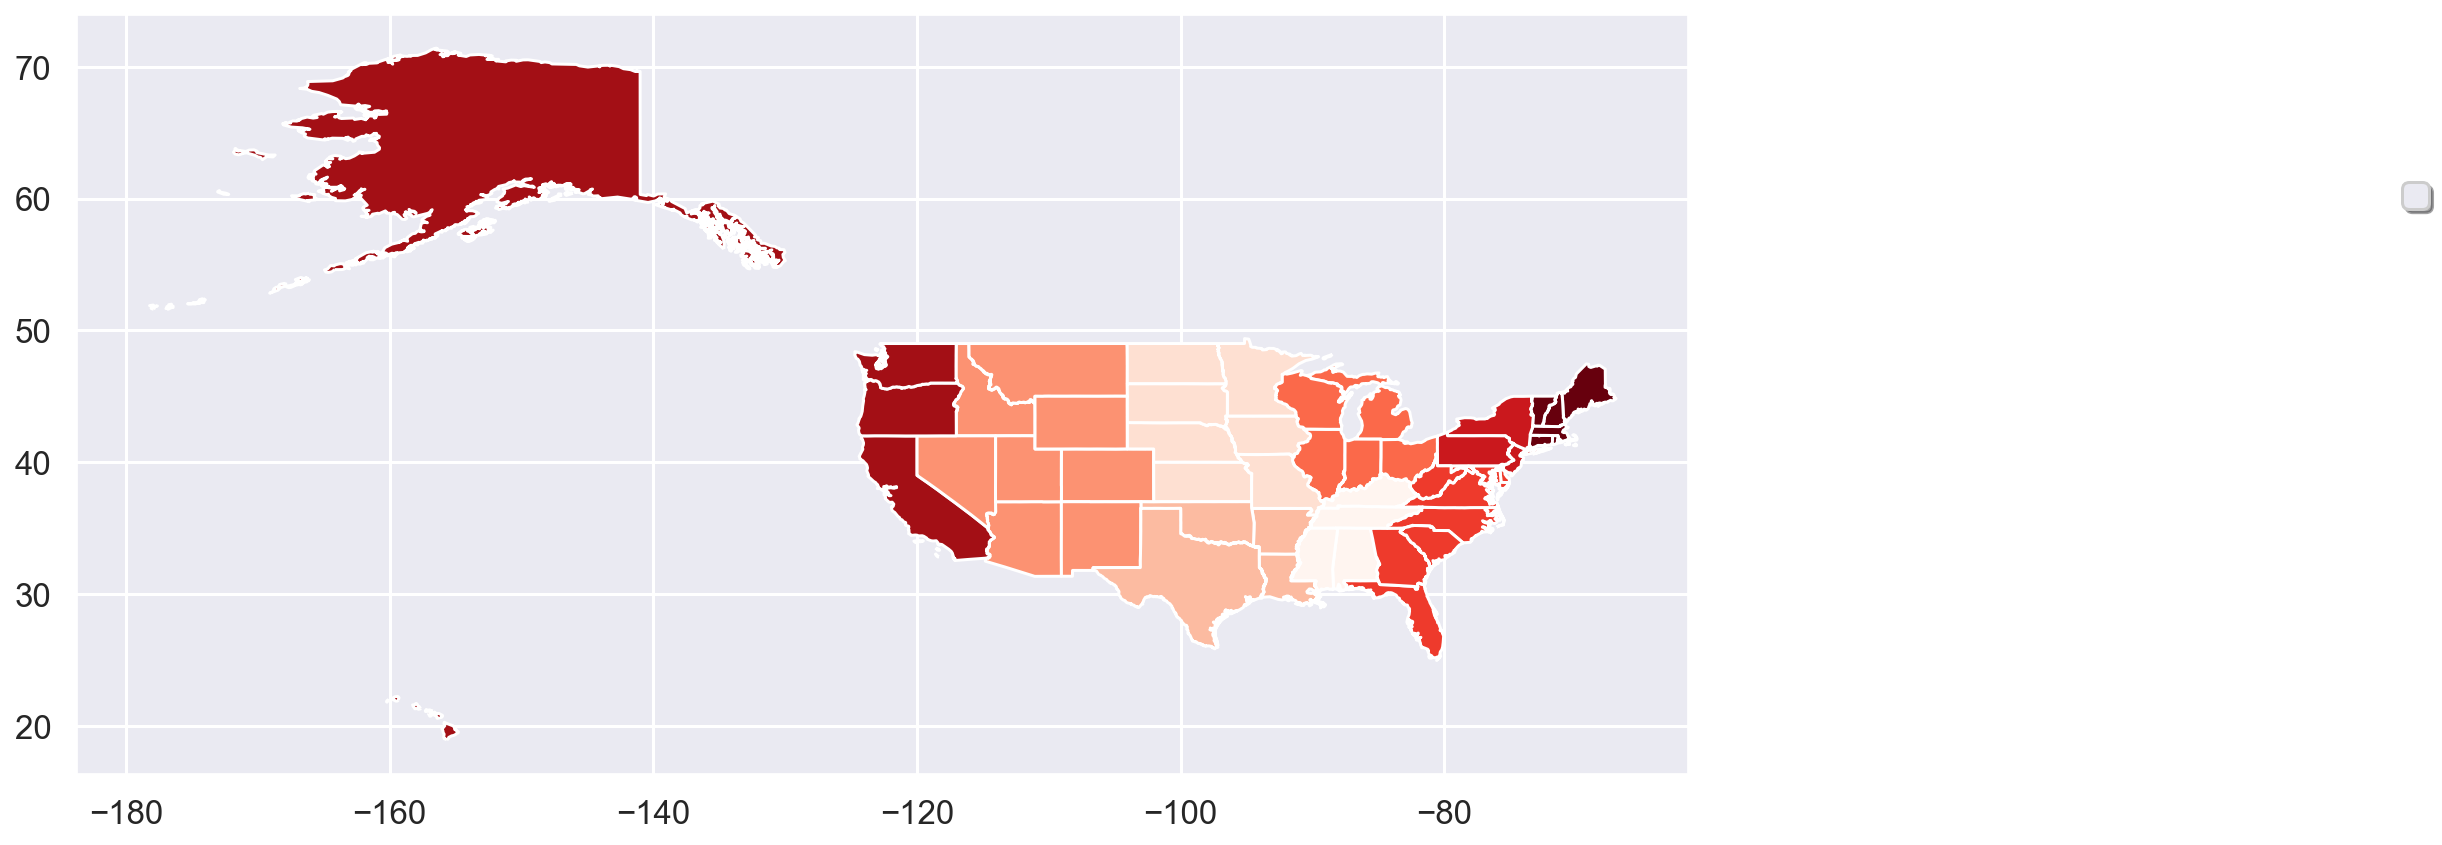

In [13]:
# Bernie Sanders
# Add division total to each state for mapping purposes
for i, row in dfBSDivision.iterrows():
    dfBSDivision.at[i,'Division Total'] =  float(dfBSDivision_State.loc[dfBSDivision_State.index == state2division[i]]["contribution_receipt_amount"])

#Drop territories and overseas army data as we are only mapping the 50 states + DC
missing_states = [0, 1, 4, 57, 14, 43, 51]
dfBSDivisionCleaned = dfBSDivision.drop(dfBSDivision.index[missing_states])

# Loading shape data for mapping
unitedstates = gpd.read_file('./states_21basic/states.shp')
unitedstates = unitedstates.sort_values(by=['STATE_ABBR'])

# Plot amount raised in each division onto map
iga, ax = plt.subplots(1, 1, figsize=(17, 7))
divider_b = make_axes_locatable(ax)
berniestates = unitedstates.plot(column=dfBSDivisionCleaned['Division Total'],ax=ax, cmap='Reds')
berniestates.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

'''
# Beto O'Rourke
# Add division total to each state for mapping purposes
for i, row in dfBODivision.iterrows():
    dfBODivision.at[i,'Division Total'] =  float(dfBODivision_State.loc[dfBODivision_State.index == state2division[i]]["contribution_receipt_amount"])

#Drop territories and overseas army data as we are only mapping the 50 states + DC
missing_states = [0, 1, 4, 57, 14, 43, 51]
dfBODivisionCleaned = dfBODivision.drop(dfBODivision.index[missing_states])

# Loading shape data for mapping
unitedstates = gpd.read_file('./states_21basic/states.shp')
unitedstates = unitedstates.sort_values(by=['STATE_ABBR'])

# Plot amount raised in each division onto map
iga, ax = plt.subplots(1, 1, figsize=(17, 7))
divider_b = make_axes_locatable(ax)
betostates = unitedstates.plot(column=dfBODivisionCleaned['Division Total'],ax=ax, cmap='Reds')
betostates.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

# Kamala Harris
# Add division total to each state for mapping purposes
for i, row in dfKHDivision.iterrows():
    dfKHDivision.at[i,'Division Total'] =  float(dfKHDivision_State.loc[dfKHDivision_State.index == state2division[i]]["contribution_receipt_amount"])

#Drop territories and overseas army data as we are only mapping the 50 states + DC
missing_states = [0, 1, 4, 57, 14, 43, 51]
dfKHDivisionCleaned = dfKHDivision.drop(dfKHDivision.index[missing_states])
    
# Loading shape data for mapping
unitedstates = gpd.read_file('./states_21basic/states.shp')
unitedstates = unitedstates.sort_values(by=['STATE_ABBR'])

# Plot amount raised in each division onto map
iga, ax = plt.subplots(1, 1, figsize=(17, 7))
divider_b = make_axes_locatable(ax)
kamalastates = unitedstates.plot(column=dfKHDivisionCleaned['Division Total'],ax=ax, cmap='Reds')
kamalastates.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
'''

# Data Analysis & Results

### I. Correlation between popularity over time and daily total donation amounts

#### Visualization

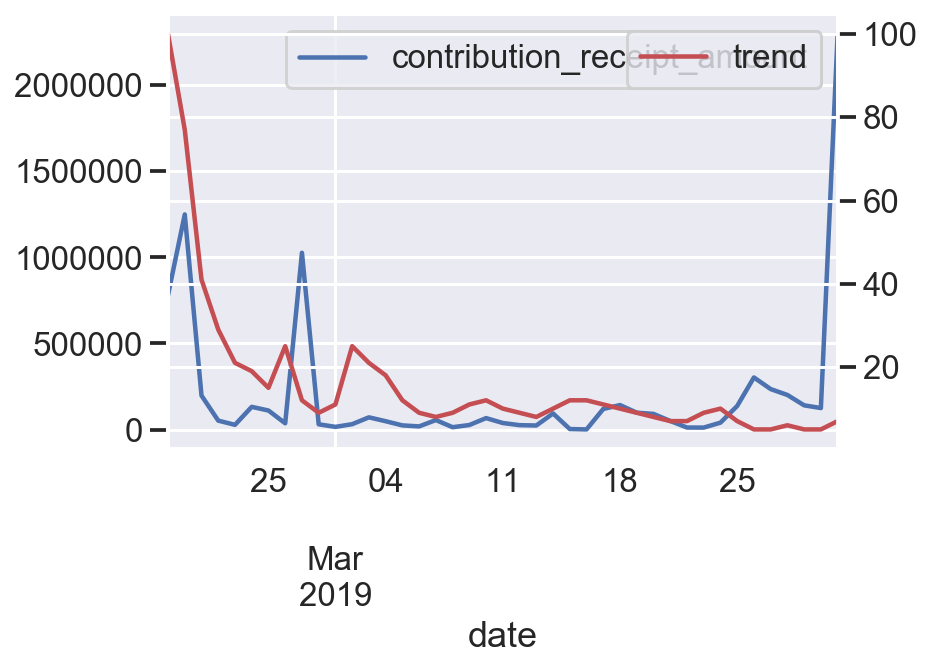

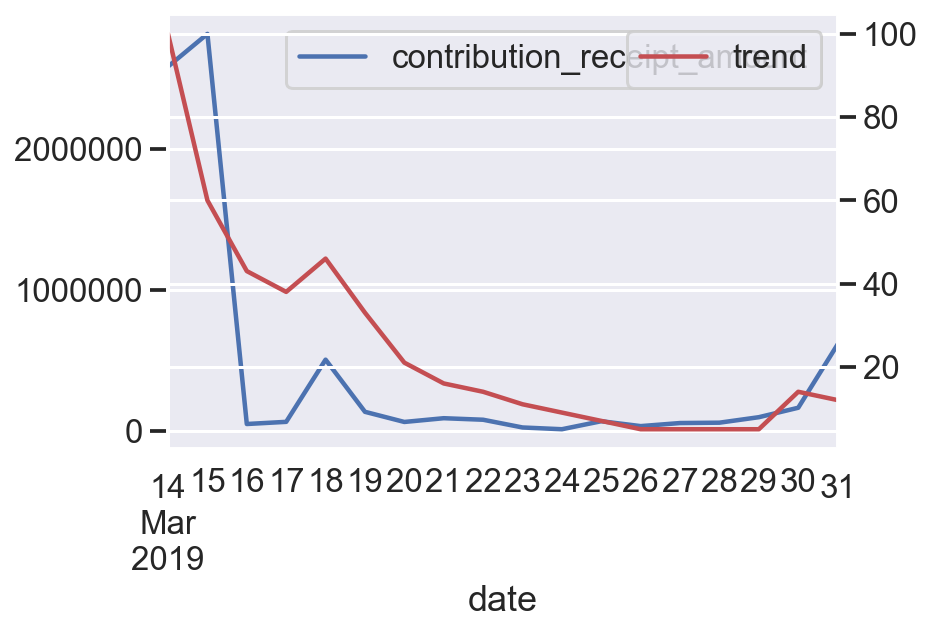

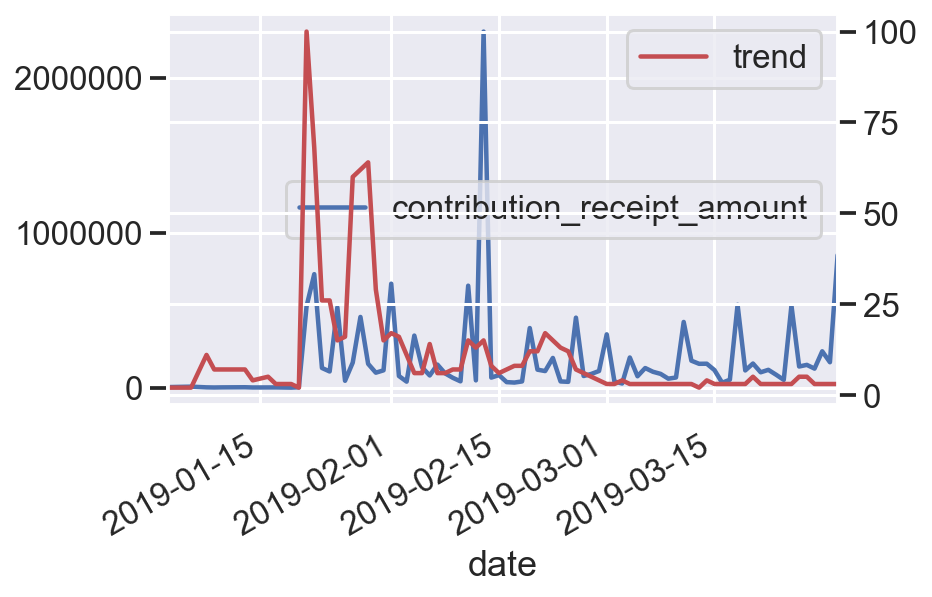

In [14]:
# Bernie Sanders
# Visually analyze correlation between Google Trends figures and total amount raised
# Merge dataframes on date
BSMerged = (pd.merge(dfBSAmount, dfBSTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
BSMerged = BSMerged.dropna()
# Plot trends and amount
ax = BSMerged.plot('date','contribution_receipt_amount')
ax1 = ax.twinx()
BSMerged.plot('date','trend',ax=ax1, color='r')

# Beto O'Rourke
# Visually analyze correlation between Google Trends figures and total amount raised
# Merge dataframes on date
BOMerged = (pd.merge(dfBOAmount, dfBOTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
BOMerged = BOMerged.dropna()
# Plot trends and amount
ax = BOMerged.plot('date','contribution_receipt_amount')
ax1 = ax.twinx()
BOMerged.plot('date','trend',ax=ax1, color='r')

# Kamala Harris
# Visually analyze correlation between Google Trends figures and total amount raised
# Merge dataframes on date
KHMerged = (pd.merge(dfKHAmount, dfKHTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
KHMerged = KHMerged.dropna()
# Plot trends and amount
ax = KHMerged.plot('date','contribution_receipt_amount')
ax1 = ax.twinx()
KHMerged.plot('date','trend',ax=ax1, color='r')

#### Regression analysis between interest over time and daily total contribution amount

In [15]:
# Bernie Sanders
# Analyze correlation between Google Trends figures and total amount raised
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", BSMerged)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.114
Model:                                     OLS   Adj. R-squared:                  0.091
Method:                          Least Squares   F-statistic:                     5.022
Date:                         Wed, 12 Jun 2019   Prob (F-statistic):             0.0308
Time:                                 17:22:52   Log-Likelihood:                -586.67
No. Observations:                           41   AIC:                             1177.
Df Residuals:                               39   BIC:                             1181.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The result shows that the correlation of the trendiness of Bernie Sanders and the total contribution to Sanders is statistically significant at the p = 0.05 level. This means that, given the null hypothesis is true that no correlation exists between trendiness and total contribution, there is only a 3.1% percent change we would observe this sample. So, for every one unit increase in trendiness, there is an approximately $7,840.78 increase in the total campaign contribution amount.

In [16]:
# Beto O'Rourke
# Analyze correlation between Google Trends figures and total amount raised
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", BOMerged)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.642
Model:                                     OLS   Adj. R-squared:                  0.620
Method:                          Least Squares   F-statistic:                     28.72
Date:                         Wed, 12 Jun 2019   Prob (F-statistic):           6.39e-05
Time:                                 17:22:52   Log-Likelihood:                -261.47
No. Observations:                           18   AIC:                             526.9
Df Residuals:                               16   BIC:                             528.7
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/kaichinshih/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


The result shows that the correlation of the trendiness of Beto O'Rourke and the total contribution to O'Rourke is statistically significant at the p = 0.05 level. In fact, the p-value associated with the trendiness of O'Rourke is 0.000, which means that, if the null hypothesis were true, there would be a 0% chance of observing the correlation. So, for every one unit increase in trendiness, there ia a $27,030 in the total campaign contribution amount, on average.

In [17]:
# Kamala Harris
# Analyze correlation between Google Trends figures and total amount raised
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", KHMerged)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.058
Model:                                     OLS   Adj. R-squared:                  0.046
Method:                          Least Squares   F-statistic:                     4.844
Date:                         Wed, 12 Jun 2019   Prob (F-statistic):             0.0307
Time:                                 17:22:52   Log-Likelihood:                -1134.3
No. Observations:                           81   AIC:                             2273.
Df Residuals:                               79   BIC:                             2277.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

For Kamala Harris, the correlation between the trendiness and her total campaign contribution amount is also statistically significant, with about the same confidence level as Bernie Sanders. With Kamala Harris, the total campaign contribution amount increases by $4,320.84 for every unit unit increase in trendiness.

### II. Correlation between popularity over time and daily total number of transactions

#### Visualization

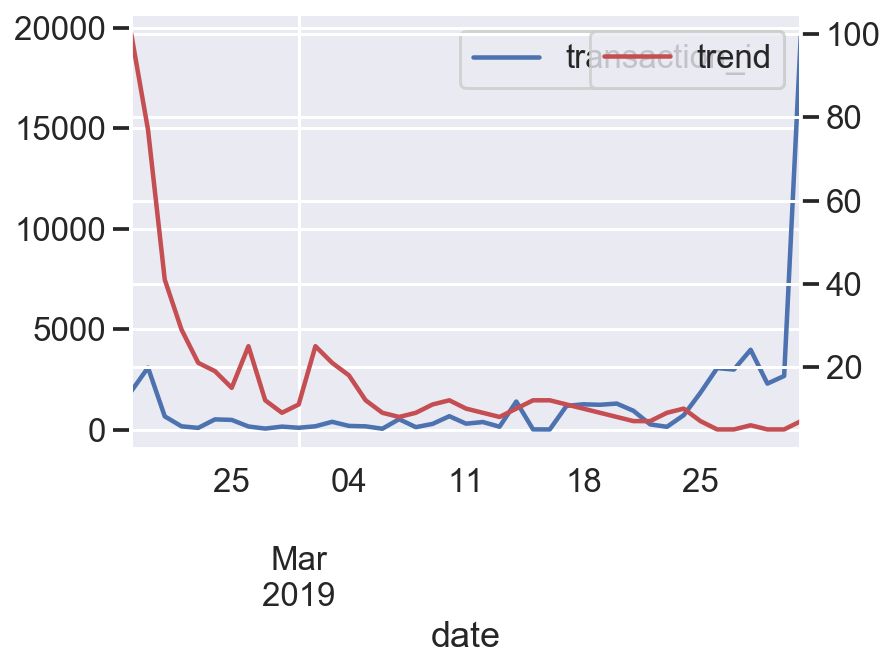

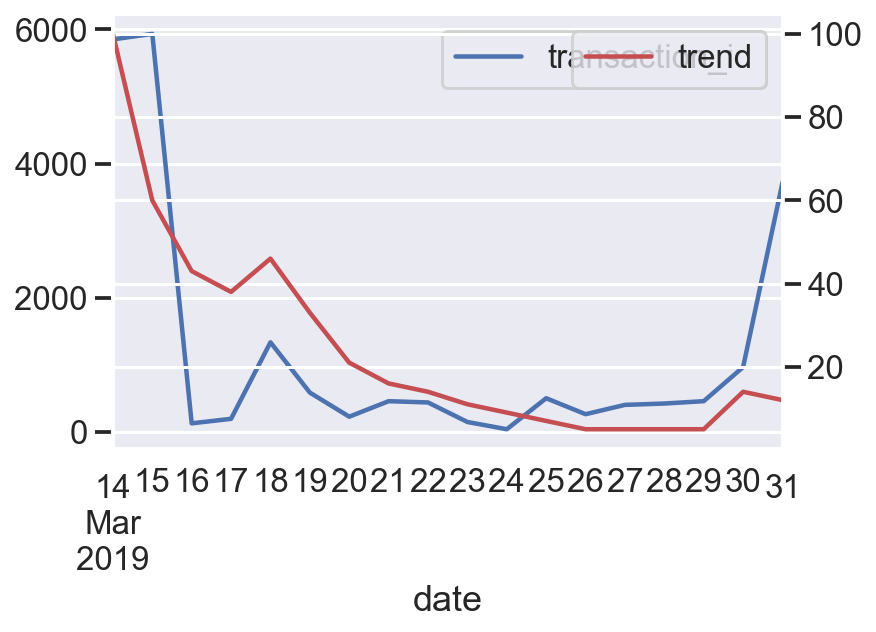

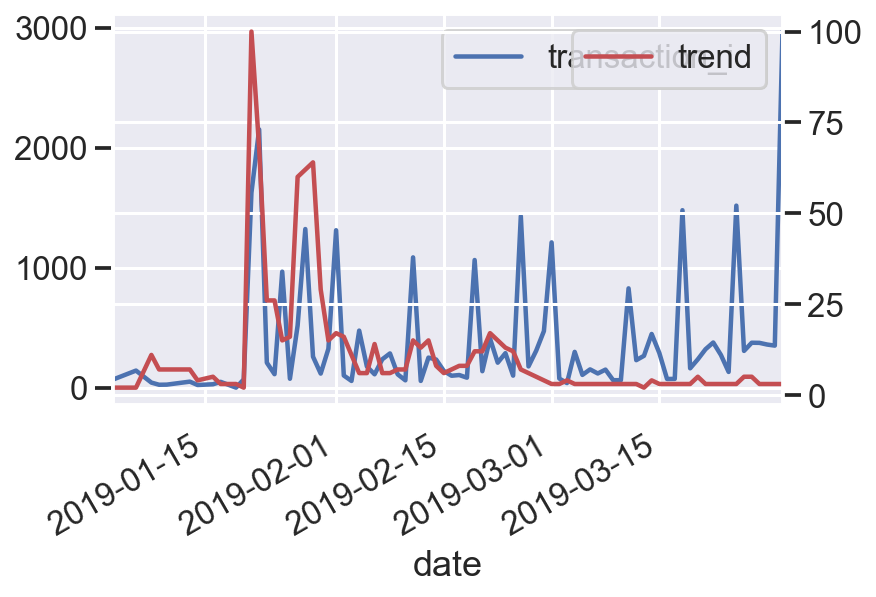

In [18]:
# Bernie Sanders
# Visually analyze correlation between Google Trends figures and total number of transactions each day
# Merge dataframes on date
BSMerged2 = (pd.merge(dfBSDonors, dfBSTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
BSMerged2 = BSMerged2.dropna()
# Plot trends and counts
ax = BSMerged2.plot('date','transaction_id')
ax1 = ax.twinx()
BSMerged2.plot('date','trend',ax=ax1, color='r')


# Beto O'Rourke
# Visually analyze correlation between Google Trends figures and total number of transactions each day
# Merge dataframes on date
BOMerged2 = (pd.merge(dfBODonors, dfBOTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
BOMerged2 = BOMerged2.dropna()
# Plot trends and counts
ax = BOMerged2.plot('date','transaction_id')
ax1 = ax.twinx()
BOMerged2.plot('date','trend',ax=ax1, color='r')

# Kamala Harris
# Visually analyze correlation between Google Trends figures and total number of transactions each day
# Merge dataframes on date
KHMerged2 = (pd.merge(dfKHDonors, dfKHTrend, how='outer', on='date'))
# Drop all dates when either fundraising amount was missing or trend data was missing
KHMerged2 = KHMerged2.dropna()
# Plot trends and counts
ax = KHMerged2.plot('date','transaction_id')
ax1 = ax.twinx()
KHMerged2.plot('date','trend',ax=ax1, color='r')

#### Regression Analysis between interest by state and total funds raised to-date by state

In [19]:
# Bernie Sanders
# Analyze correlation between Google Trends figures and total number of transactions each day
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("transaction_id~trend", BSMerged2)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:         transaction_id   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                   0.02265
Date:                Wed, 12 Jun 2019   Prob (F-statistic):              0.881
Time:                        17:22:57   Log-Likelihood:                -387.36
No. Observations:                  41   AIC:                             778.7
Df Residuals:                      39   BIC:                             782.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1426.3240    655.198      2.177      0.0

Based on the OLS Regression Results, the correlation between trendiness and unique donors for Bernie Sanders is not statistically significant. The p-value, .881, is much larger than the expected value of 0.05. Thus, we are forced to reject our null hypothesis that the amount of unique donors increases as a candidate's trendiness rises. In fact, the model indicates that there is a roughly 4-member decrease in unique donors for each unit increase in trendiness. Thus, it is certainly not a positive correlation, or a statistically significant negative correlation for that matter.

In [20]:
# Beto O'Rourke
# Analyze correlation between Google Trends figures and total number of transactions each day
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("transaction_id~trend", BOMerged2)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:         transaction_id   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     17.10
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           0.000777
Time:                        17:22:57   Log-Likelihood:                -154.27
No. Observations:                  18   AIC:                             312.5
Df Residuals:                      16   BIC:                             314.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -103.4215    453.411     -0.228      0.8

/Users/kaichinshih/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In Beto O'Rourke's case, the correlation is statistically significant. For every unit increase in trendiness, there is a roughly 54 person increase in the number of unique donors O'Rourke receives. This finding is statistically significant at the p = 0.05 level.

In [21]:
# Kamala Harris
# Analyze correlation between Google Trends figures and total number of transactions each day
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("transaction_id~trend", KHMerged2)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:         transaction_id   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     12.48
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           0.000690
Time:                        17:22:57   Log-Likelihood:                -616.98
No. Observations:                  81   AIC:                             1238.
Df Residuals:                      79   BIC:                             1243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    257.5300     66.713      3.860      0.0

In the case of Kamala Harris, the finding is statistically significant as well, with a roughly 11 person increase in unique donors for every unit increase in trendiness.

### III. Correlation between popularity and total funds raised to-date by state

#### Visualization on trend

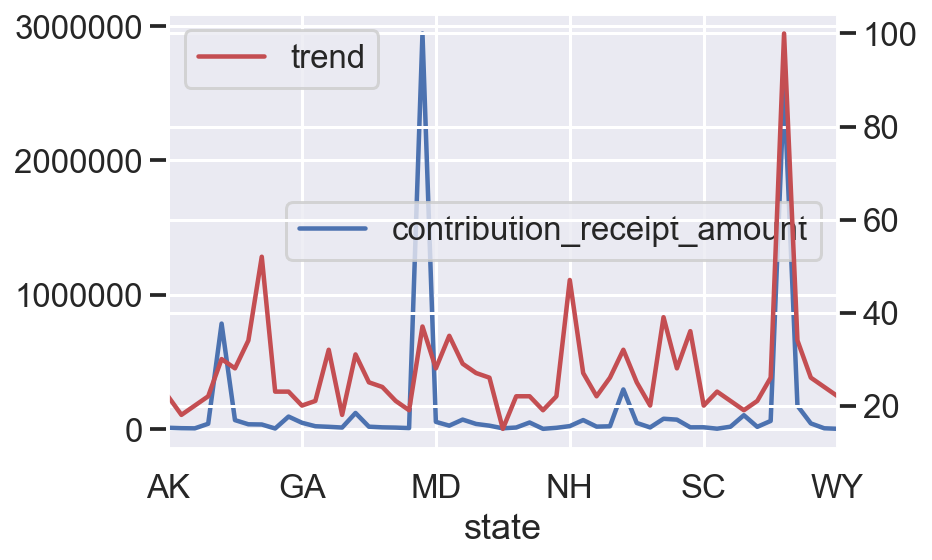

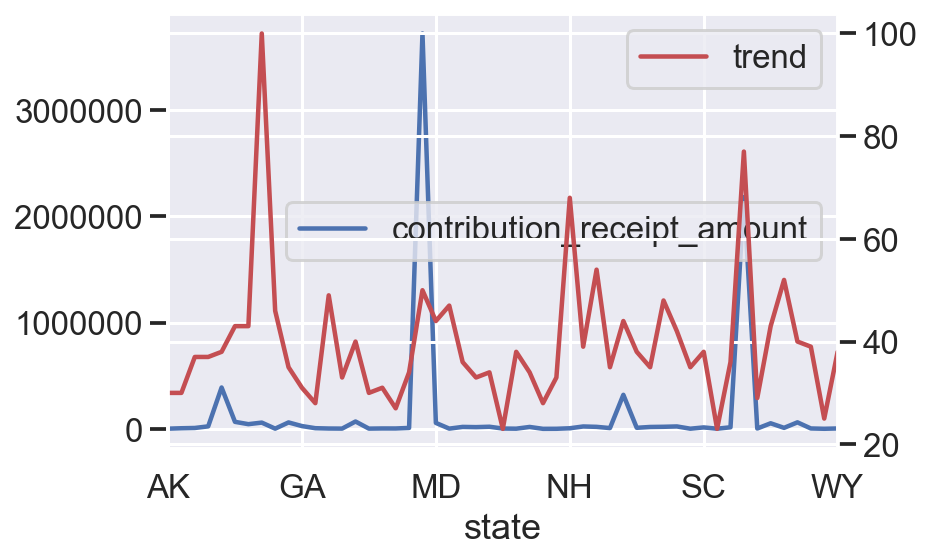

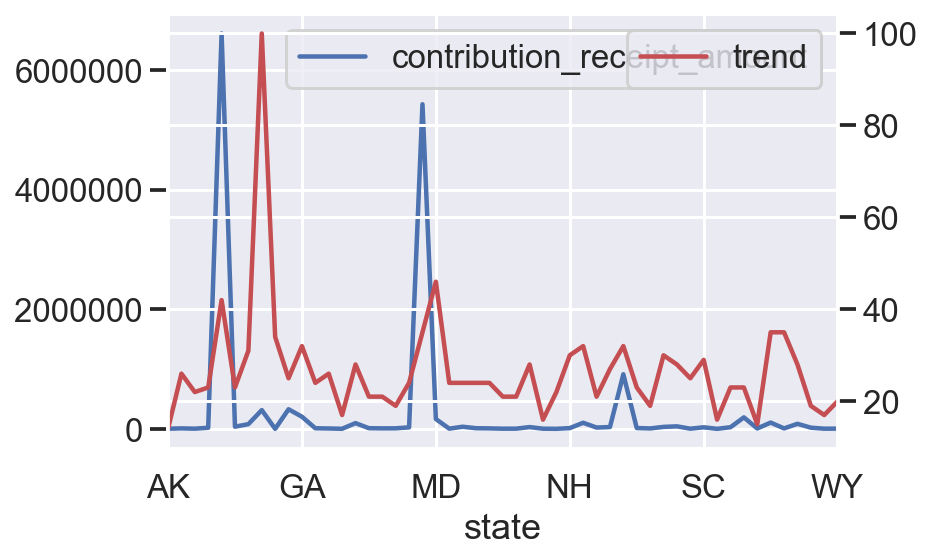

In [22]:
# Bernie Sanders
# Visually analyze correlation between Google Trends figures and total amount raised by states 
# Merge dataframes on state
BSMerged3 = (pd.merge(dfBSStates, dfBSTrendStates, how='outer', on='state'))
# Drop all states when either fundraising amount was missing or trend data was missing
BSMerged3 = BSMerged3.dropna()
# Plot trends and amount
ax = BSMerged3.plot('state','contribution_receipt_amount')
ax1 = ax.twinx()
BSMerged3.plot('state','trend',ax=ax1, color='r')


# Beto O'Rourke
# Visually analyze correlation between Google Trends figures and total amount raised by states 
# Merge dataframes on state
BOMerged3 = (pd.merge(dfBOStates, dfBOTrendStates, how='outer', on='state'))
# Drop all states when either fundraising amount was missing or trend data was missing
BOMerged3 = BOMerged3.dropna()
# Plot trends and amount
ax = BOMerged3.plot('state','contribution_receipt_amount')
ax1 = ax.twinx()
BOMerged3.plot('state','trend',ax=ax1, color='r')

# Kamala Harris
# Visually analyze correlation between Google Trends figures and total amount raised by states 
# Merge dataframes on state
KHMerged3 = (pd.merge(dfKHStates, dfKHTrendStates, how='outer', on='state'))
# Drop all states when either fundraising amount was missing or trend data was missing
KHMerged3 = KHMerged3.dropna()
# Plot trends and amount
ax = KHMerged3.plot('state','contribution_receipt_amount')
ax1 = ax.twinx()
KHMerged3.plot('state','trend',ax=ax1, color='r')

#### Regression Analysis

In [23]:
# Bernie Sanders
# Analyze correlation between Google Trends figures and total amount raised by each state
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", BSMerged3)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.398
Model:                                     OLS   Adj. R-squared:                  0.386
Method:                          Least Squares   F-statistic:                     32.42
Date:                         Wed, 12 Jun 2019   Prob (F-statistic):           6.92e-07
Time:                                 17:22:59   Log-Likelihood:                -732.16
No. Observations:                           51   AIC:                             1468.
Df Residuals:                               49   BIC:                             1472.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In Bernie Sander's case, the Google trends is statistically correlated to the total amount raised by states, since the coef is not zero and P value smaller than 0.05.

In [24]:
# Beto O'Rourke
# Analyze correlation between Google Trends figures and total amount raised by states
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", BOMerged3)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.100
Model:                                     OLS   Adj. R-squared:                  0.081
Method:                          Least Squares   F-statistic:                     5.424
Date:                         Wed, 12 Jun 2019   Prob (F-statistic):             0.0240
Time:                                 17:22:59   Log-Likelihood:                -747.42
No. Observations:                           51   AIC:                             1499.
Df Residuals:                               49   BIC:                             1503.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In Beto O'Rourke's case, his trendiness is correlated with the amount of campaign donations he secures in each state in a statistically significant manner. For each unit increase in trendiness, there is a $14240 increase in the total contribution amount from a single state, on average.

In [25]:
# Kamala Harris
# Analyze correlation between Google Trends figures and total amount raised by states
# Looking for the correlation between by applying OLS linear regression
outcome_1, predictors_1 = patsy.dmatrices("contribution_receipt_amount~trend", KHMerged3)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     contribution_receipt_amount   R-squared:                       0.059
Model:                                     OLS   Adj. R-squared:                  0.040
Method:                          Least Squares   F-statistic:                     3.066
Date:                         Wed, 12 Jun 2019   Prob (F-statistic):             0.0862
Time:                                 17:22:59   Log-Likelihood:                -783.47
No. Observations:                           51   AIC:                             1571.
Df Residuals:                               49   BIC:                             1575.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In Kamala Harris's case, trendiness and contribution amount from each state is not correlated in a statistically signficant manner.There is a $23200 increase in the total contribution amount from a state with every one unit increase in trendiness.

#### Visualization on map

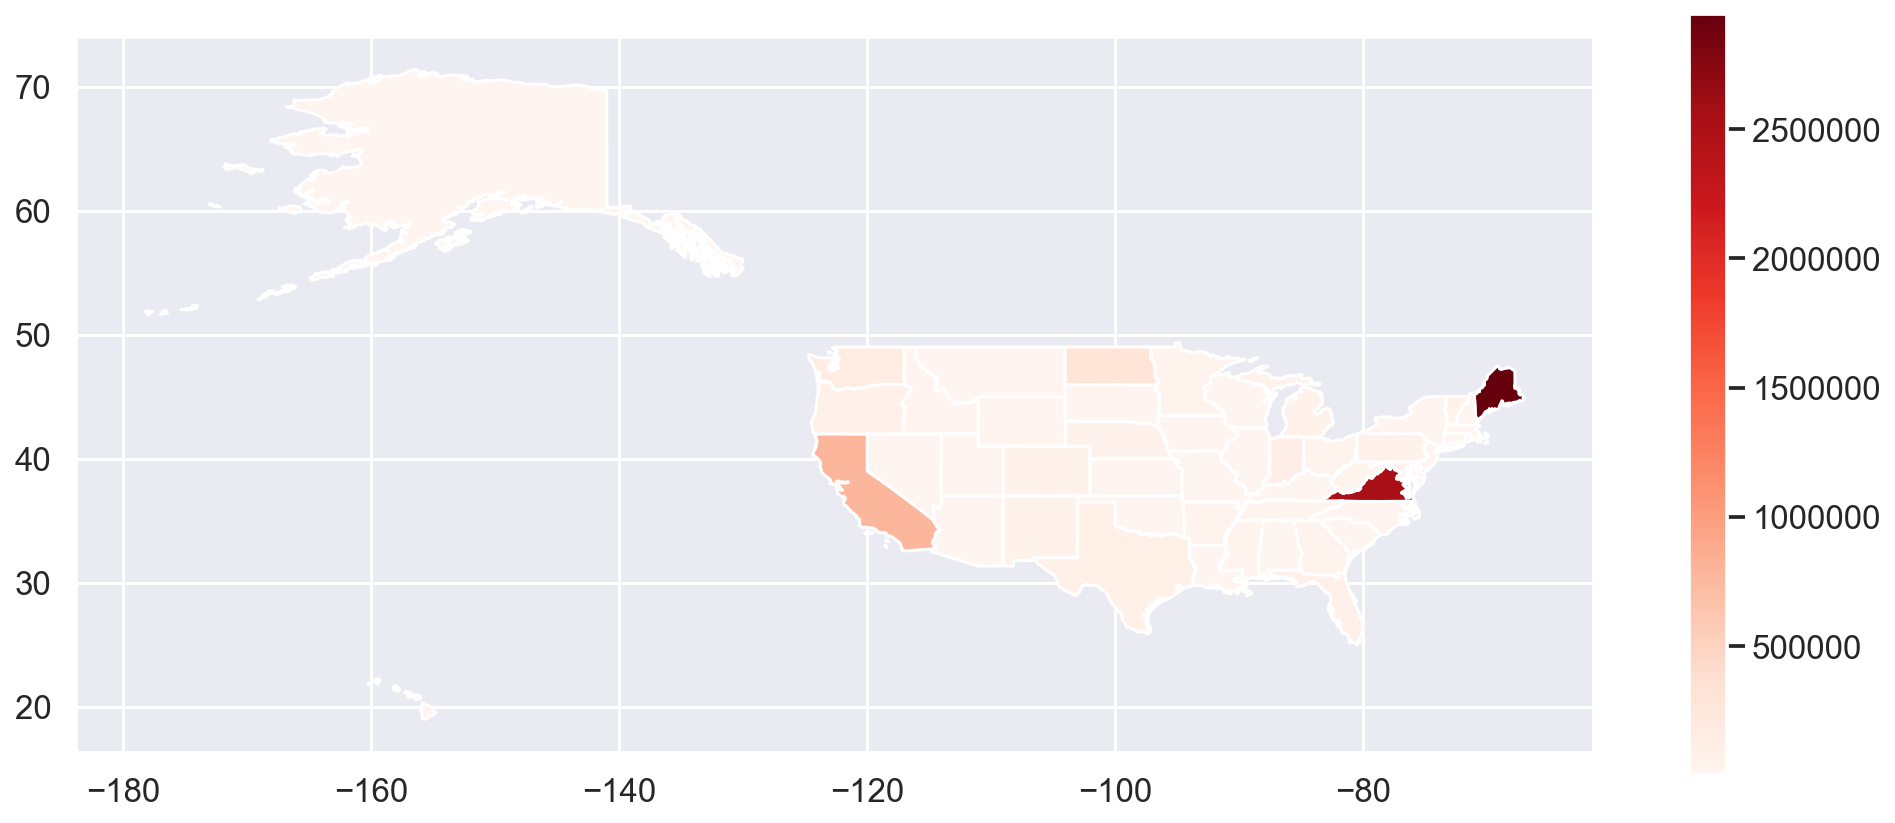

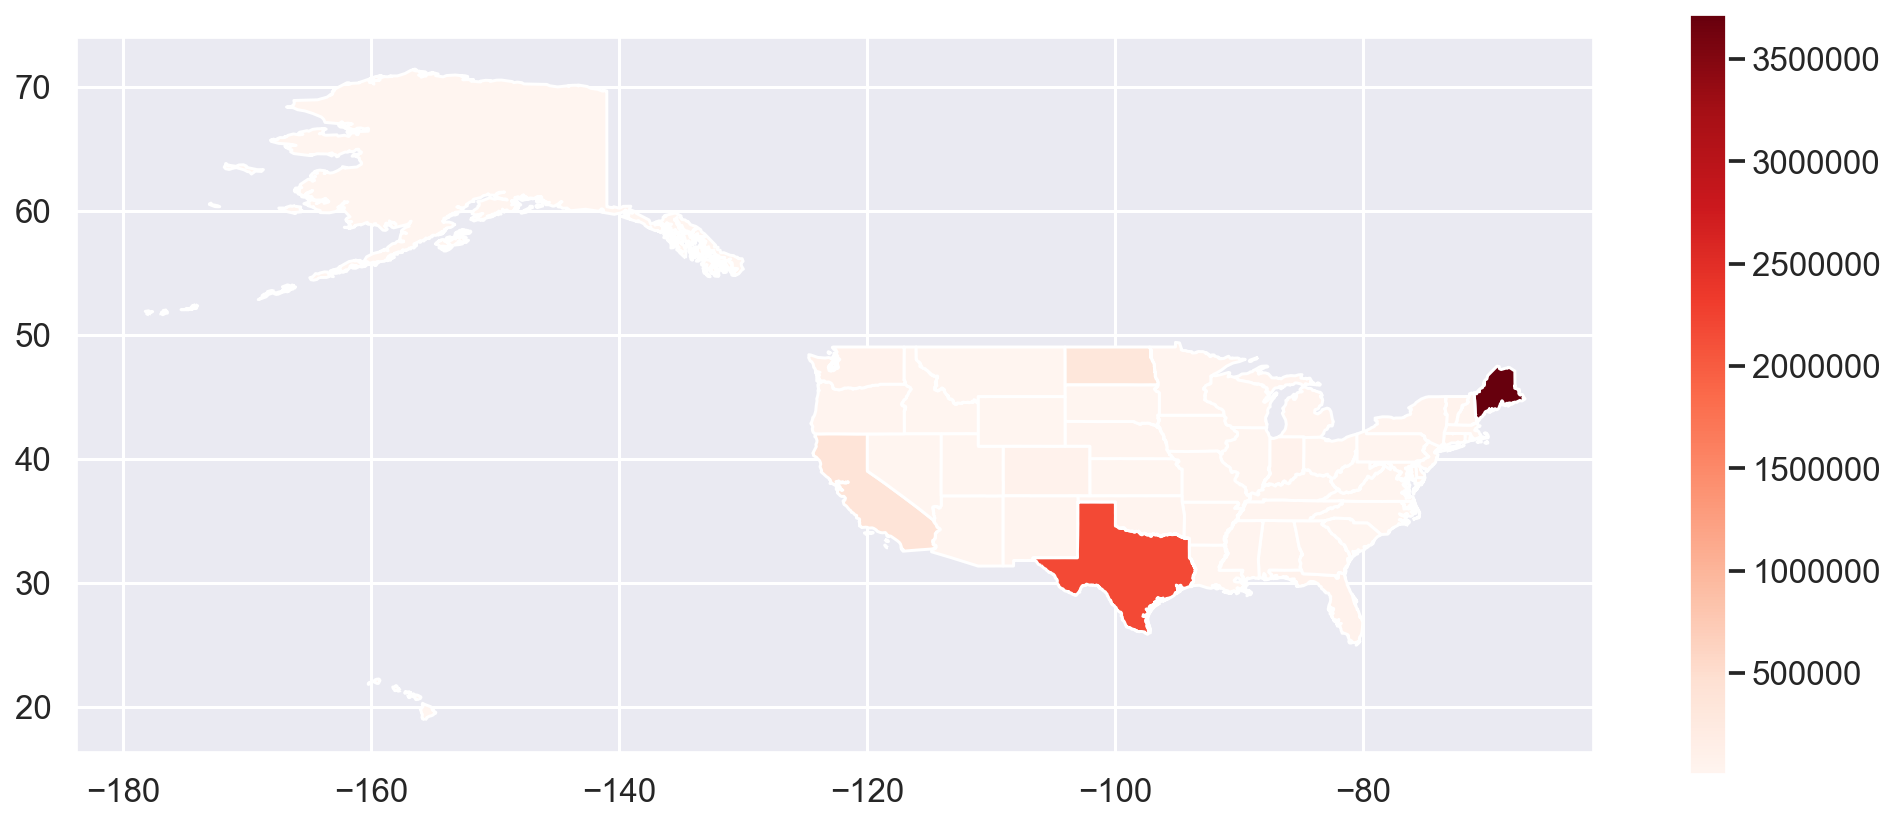

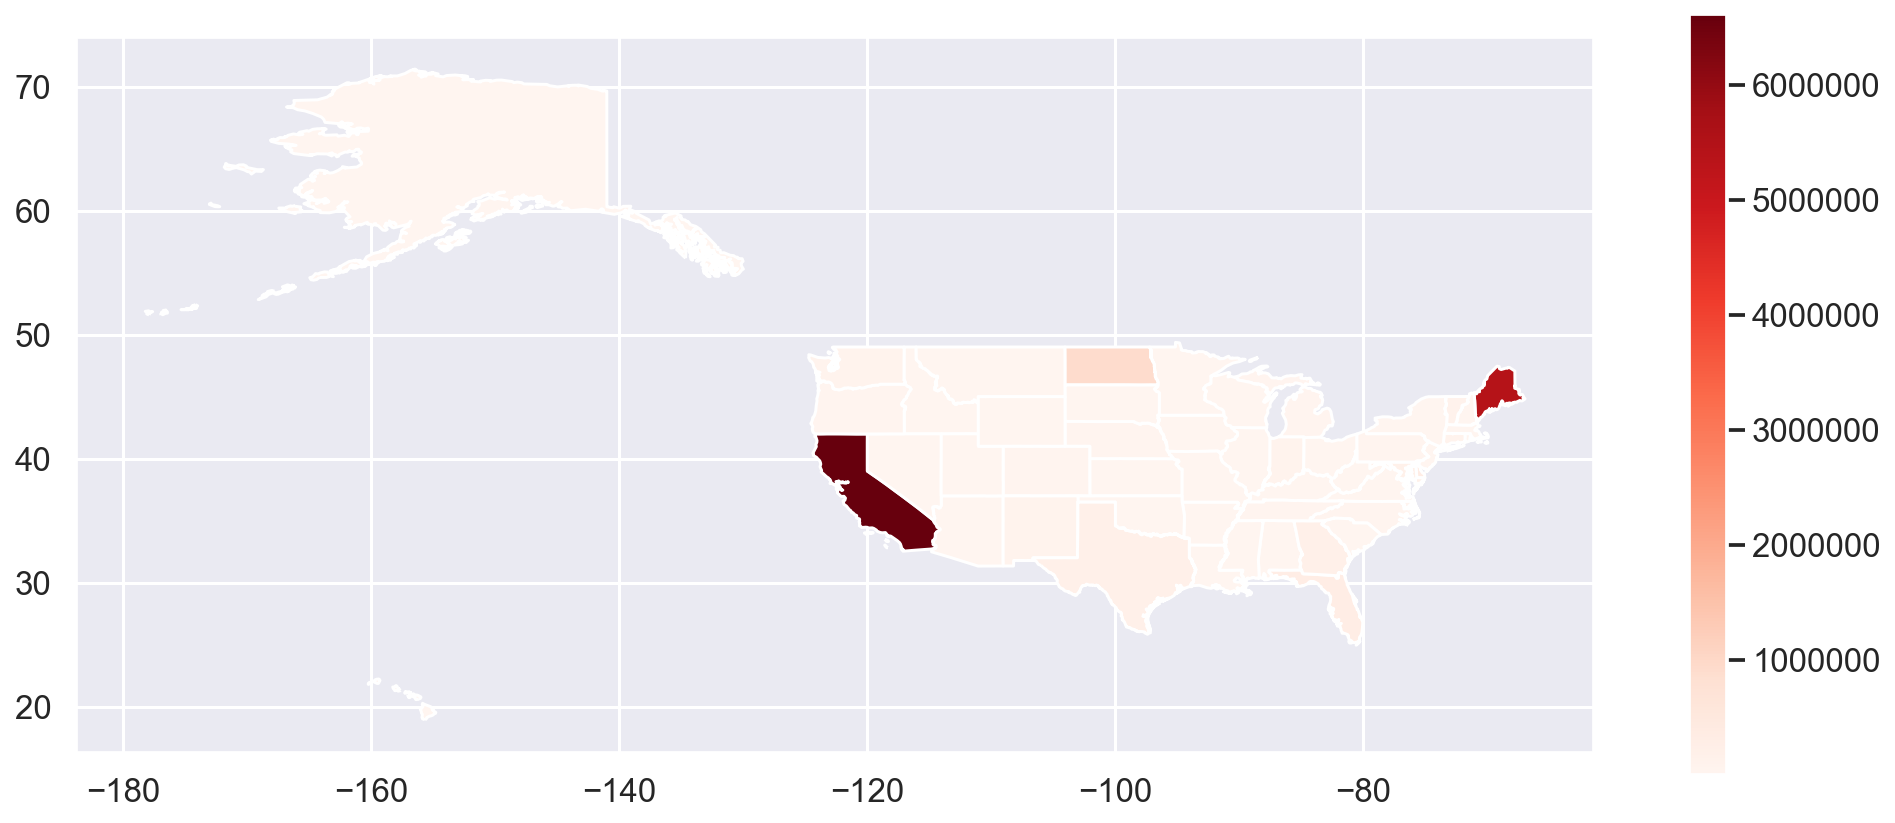

In [26]:
# Bernie Sanders
# Color each state based on total funds raised
usa = usa.sort_values(by=['STATE_NAME'])
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=BSMerged3['contribution_receipt_amount'],ax=ax, cmap='Reds', legend=True);

# Beto O'Rourke
# Color each state based on total funds raised
usa = usa.sort_values(by=['STATE_NAME'])
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=BOMerged3['contribution_receipt_amount'],ax=ax, cmap='Reds', legend=True);

# Kamala Harris
# Color each state based on total funds raised
usa = usa.sort_values(by=['STATE_NAME'])
ig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
usa.plot(column=KHMerged3['contribution_receipt_amount'],ax=ax, cmap='Reds', legend=True);

# Ethics & Privacy

Our data collection process itself was not affected by ethical dilemmas because both the Census data and campaign contribution amounts were publically available. Our Google trends data is slightly biased in that the popularity rankings given to us per candidate are all relative; the exact number of Google searches per region or per state is not provided to us. Instead, the ranking simply shows us where a candidate experiences hsi highest popularity, and then provides a relative popularity for every other state. For example, since Bernie Sanders has his highest popularity in Vermont, Vermont is given a 100 by Google Trends. The popularity of every other state in terms of search rates is then ranked in comparision, which would indicate that, roughly, for every 100,000 searches a candidate receives in Vermont, he receives 40,000 searches in a state with a ranking of 40. Thus, there is likely a slight skew in how the data is presented. The FEC (Federal Election Commission) data is not subject to this bias because the quantitative values are definitive and accurate.

# Conclusion & Discussion

Our hypothesis that the total contribution amount, total number of unique donors, and total contribution amount by each state will increase when the candidates’ trendiness rises. Generally, our hypothesis was proven correct, with a few exceptions in certain instances. The total contribution amount is correlated with a candidate's trendiness overtime in a statistically significant manner for all three candidates. So, for all three candidates, we can reject the null hypothesis that the total contribution amount overtime is not correlated with a candidate's trendiness. A limitation in our analysis is that our adjusted R^2 values are inconsistent across each candidate. So, even though we can confirm that we can reject the null hypothesis, we know that the amount of variation of total contribution amount accounted for by the candidate's popularity varies across candidate, which is expected but simultaneously important to consider.

The total number of unique donors was correlated with trendiness overtime for a candidate in a statistically significant manner for Kamala Harris and Beto O'Rourke but not for Bernie Sanders. Thus, in the case of Bernie Sanders, we fail to reject the null hypothesis that a candidate's number of unique donors has no effect on the candidate's popularity overtime. The fact that we are forced to fai to reject our null hypothesis for a candidate points to a limitation in our analysis. We cannot make the sweeping generalization that a correlation exists between trendiness overtime and the number of unique donors overtime, as it does not hold true across all the candidates we choose to analyze.



